<a href="https://colab.research.google.com/github/SKYUTS/MachineLearning-AI-/blob/main/TeleMarketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment

## Optimisation with respect to Offer and Call Cost
It is assumed those customers (feature: campaign=0) have not been targeted by campaign (Control Group) and if their response value is positive, it means they natrually applied for product with no discount and call cost. Hence, we can categorise the customers in 4 categories based on this assumption:

1) **Control: Customers who are not targeted by campaign but applied naturally: [campaign=0, response=1]**

2) **Control: Customers who are not targeted by campaign and didn't apply: [campaign=0, response=0]**

3) **Target: Customers who are targeted by campaign and respond positively: [campaign=1, response=1]**

4) **Target: Customers who are targeted by campaign and respond negatively: [campaign=1, response=0]**

We also assume that the Customer Lifetime Value(CLV) is equal for every customer and the company gain will be the same for every customer who buys the product. Hence, the gain value of conversion for each customer is the same and I give value of 200 unit benefit.  

Taking above assumptions into account, the objective of campaign will be maximising the conversion rate and minimising the conversion cost simultaneously. Therefore, if we can define a score for each customer that takes this objective into account, the score should represents the liklihood of a customer buying product for different cost scenarios. The cost factor is the combination of discount cost and call cost:

- *Discount cost is a binary scenario. If customer are targeted by campaign(campaign=1), then discount cost would be 100 unit cost, otherwise it would be 0.*


- *Call cost is a little bit more complicated. we assume 11 buckets of time-intervals for call duration and then I assign cost for each bucket. The call cost would be 0 for the first bucket, this bucket represents duration=0 which means the customer has not been targted and contacted. For the rest of buckets, I assume 2 unit cost that woulde be accumlated through the buckets up to 10th bucket,e.g. {bucket0:0, bcuket1:2, bucket2:4, bucket3:6, ..., bucket10:20}.*

Given above assumptions, we can define the following score:

***Score =  SUM [200*                 P(Y=1|Campaign=0,Duration=bucket(0)) +
                (100-Cost(bucket(i))* P(Y=1|Campaign=1, Duration=bucket(i))]**
         

The score is the sum of two components. The first componenet of score is the case in which a customer buys the product natrually with no cost. The second component of score indicates the scenario that a customer is targeted by campaign and given the discount. In this scenario the more time takes to convince customer, the more call cost is involved. Both of the scenarios include the likelihood that a customer response is positive.

Goven these assumptions, you are required to implement ML-based solution that provides ranking of customers based on their score.

In [ ]:
!pip install ydata-profiling

In [ ]:
import warnings
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import RFE , f_classif, chi2, SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from xgboost.sklearn import XGBClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import dump, load

mount to your google drive and access to shared data in your drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
RANDOM_SATE = 123

In [ ]:
def read_data(path):
    return pd.read_csv(path)

In [ ]:
cat_features=['job', 'marital', 'education', 'default', 'housing','loan',
              'poutcome','previous','month','day_of_week','contact','campaign']
num_features=['age','cons.price.idx', 'cons.conf.idx','duration']

In [ ]:
data = read_data(path='/content/drive/MyDrive/TeleMarketing.csv')
print(data.shape)

(41188, 17)


Create a data profile for data using Panda Data profiler

In [ ]:
prof = ProfileReport(data)
prof.to_file(output_file='EDA.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Cleaning
Looking at data profile, following quick data prepration is needed:
- Remove duplicates
- Impute null values
- Convert some numerical features to catogorical

In [ ]:
data = data.drop_duplicates()
data["contact"].fillna("Not Applicable", inplace = True)

# TODO 1: fill the null values in variables "month" and "days_of_week" with "Not Applicable"
# Edit the code by replacing the underscore
data["month"]._________
data["day_of_week"]._________
data['previous']= data['previous'].apply(str)
data['campaign']= data['campaign'].apply(str)
campaign_data= data.copy(deep=True)
print(campaign_data.shape)

(35438, 17)


## Data Exploration
Plot countplot to get more insight about categorical features in regards to response value.

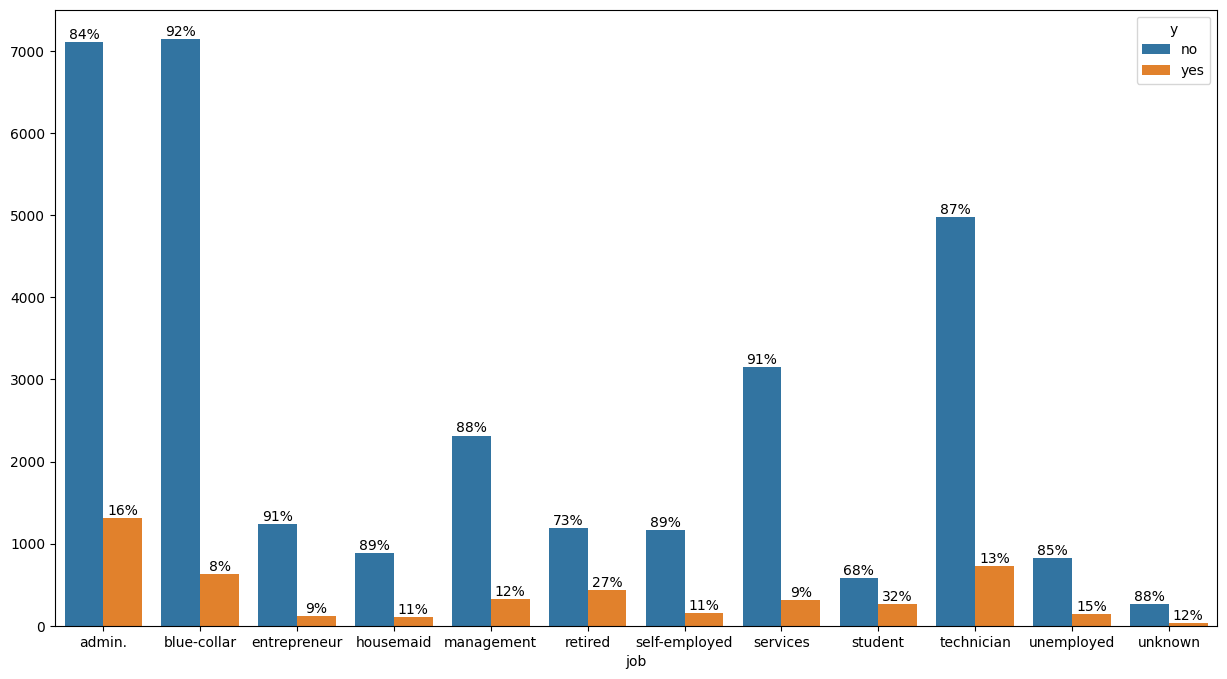

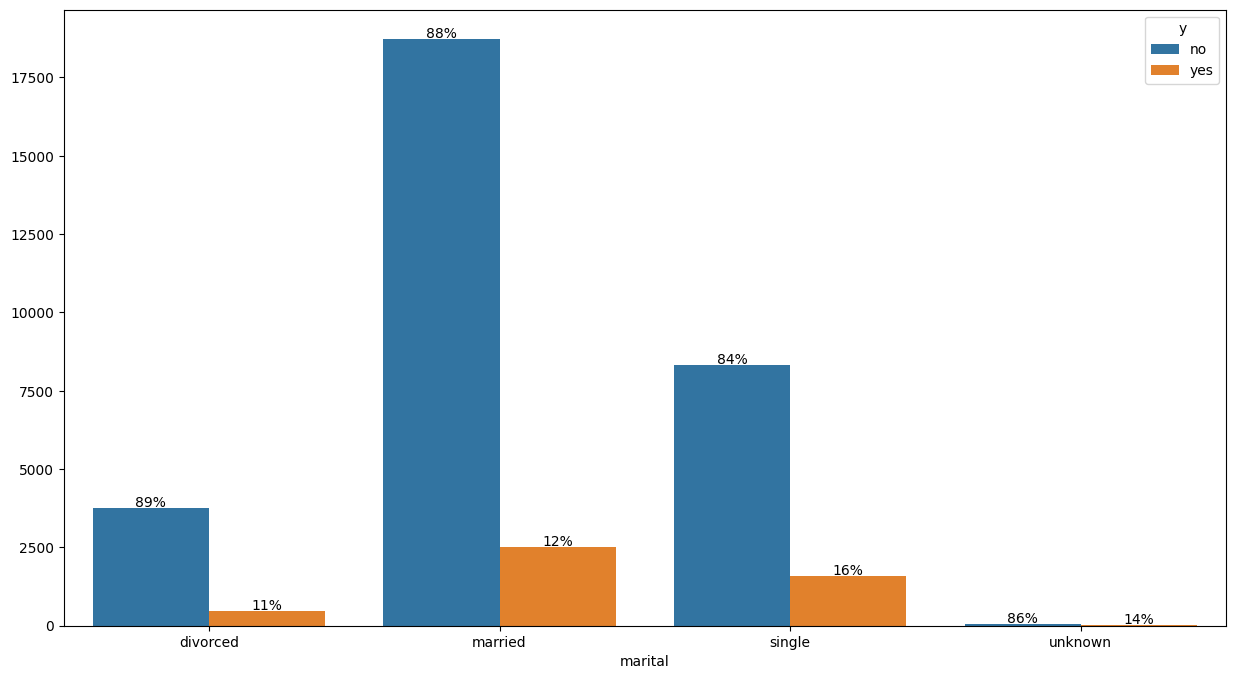

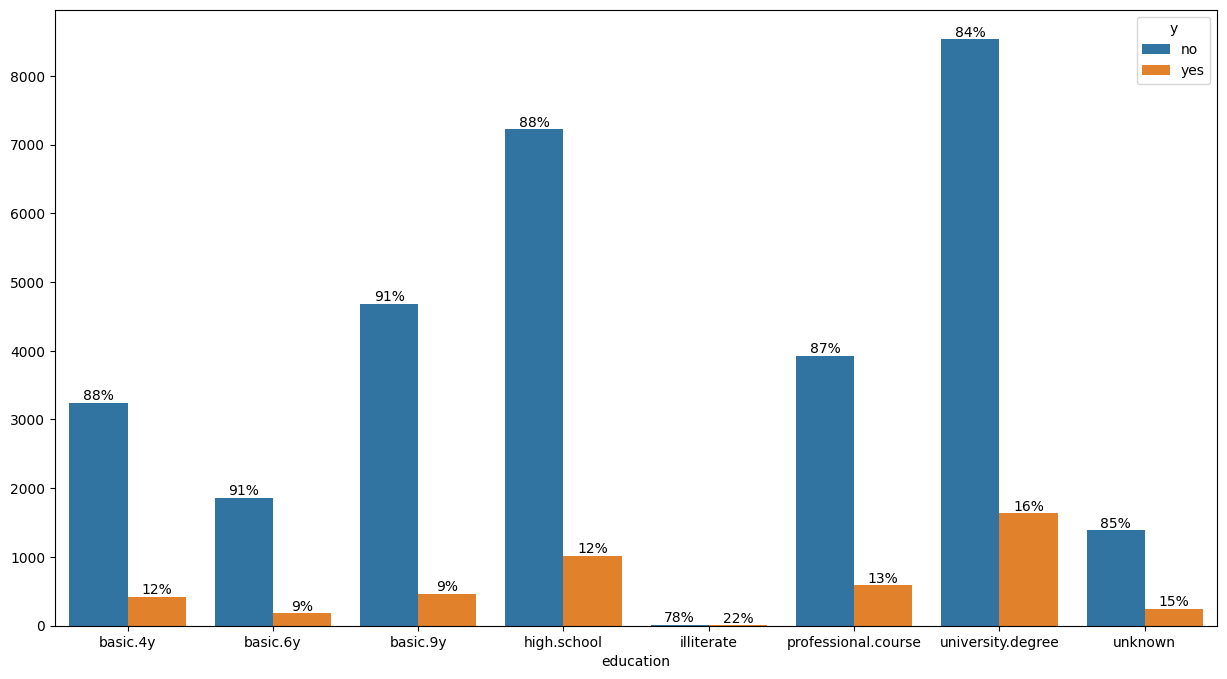

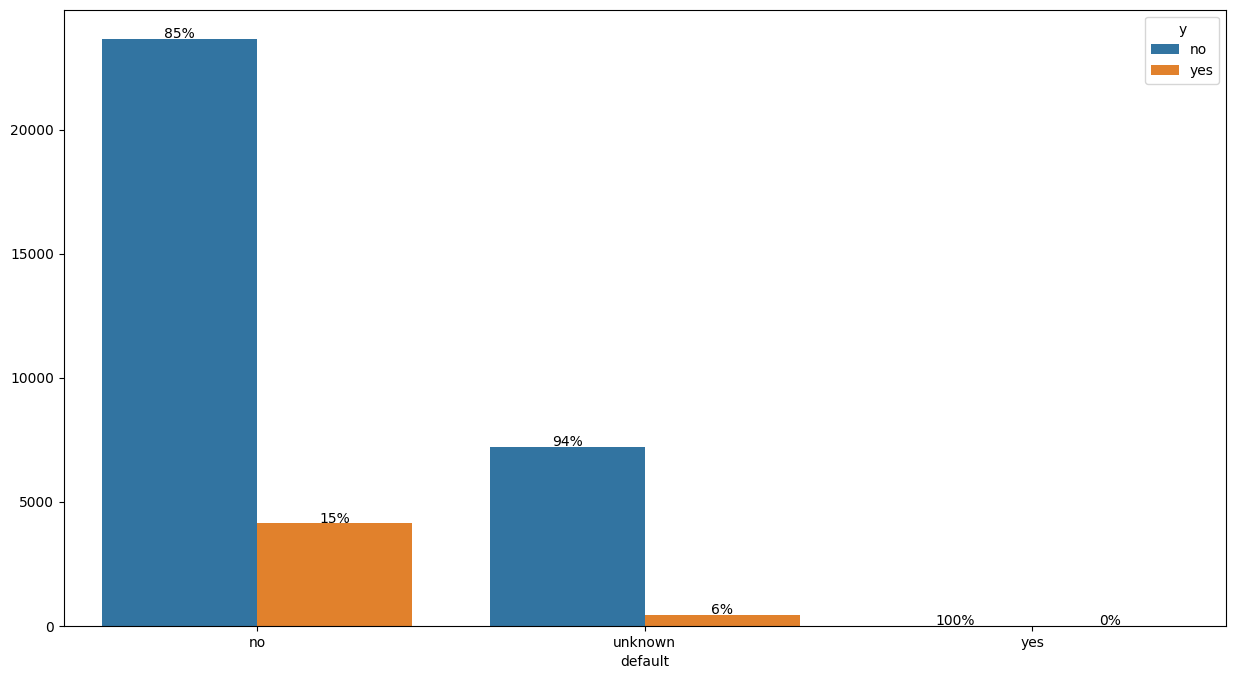

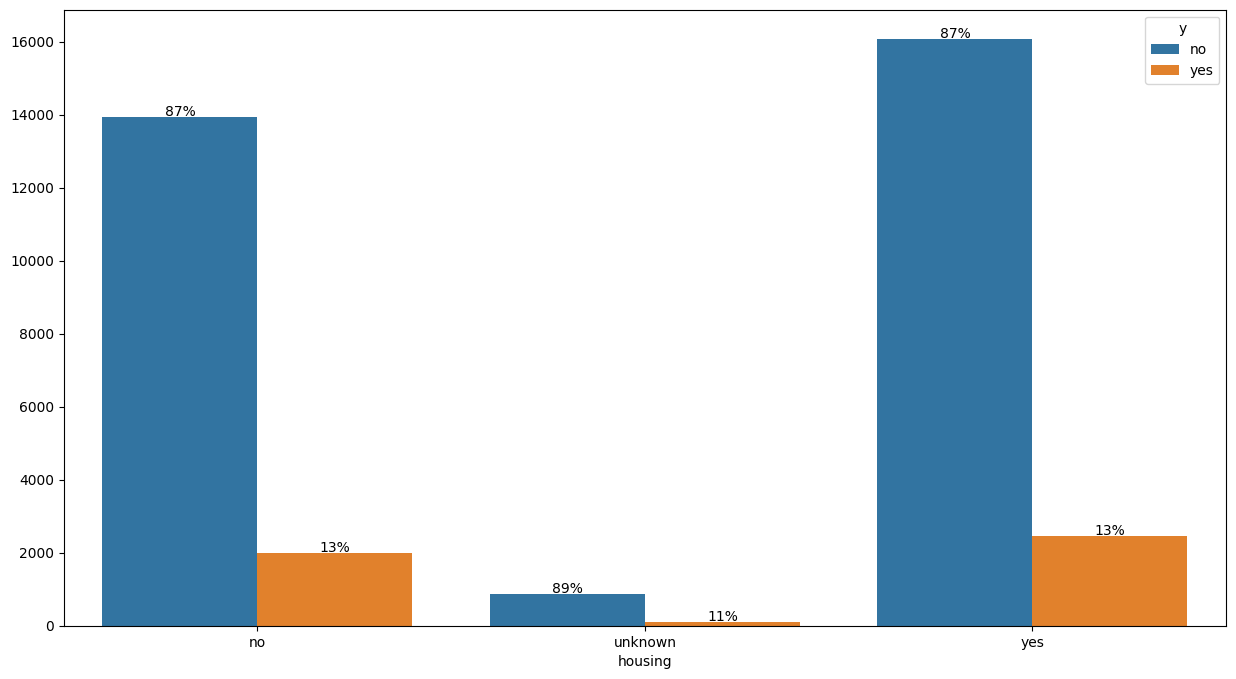

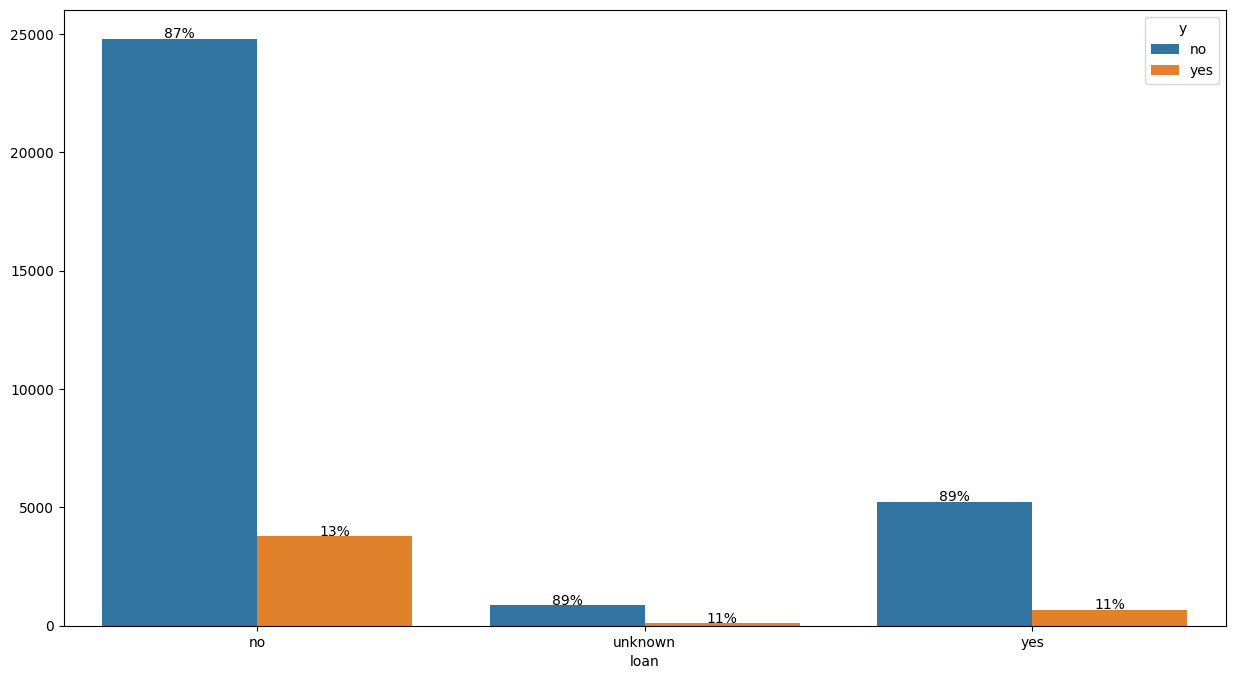

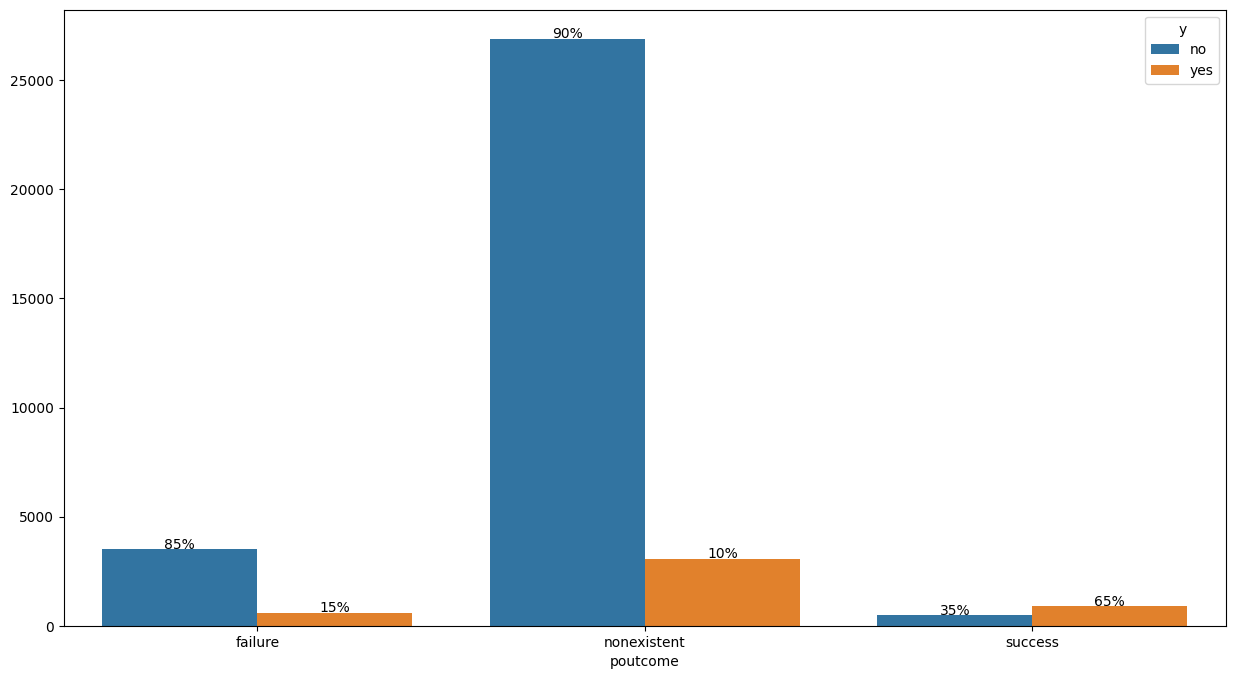

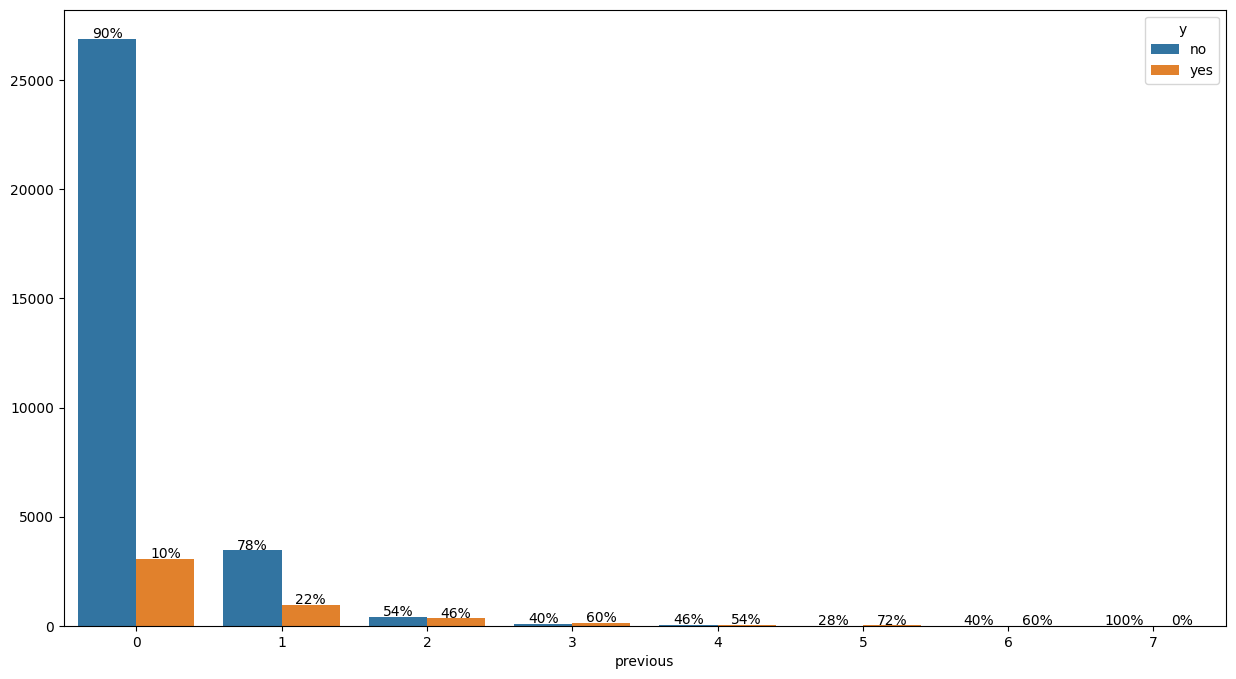

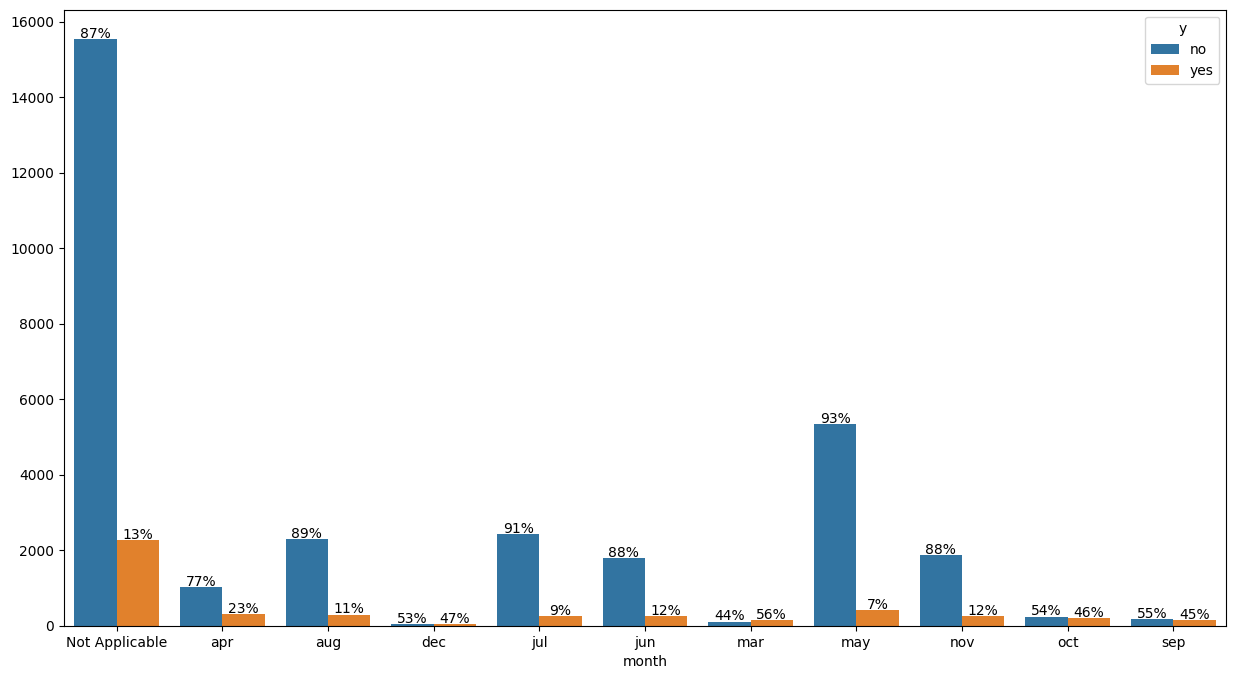

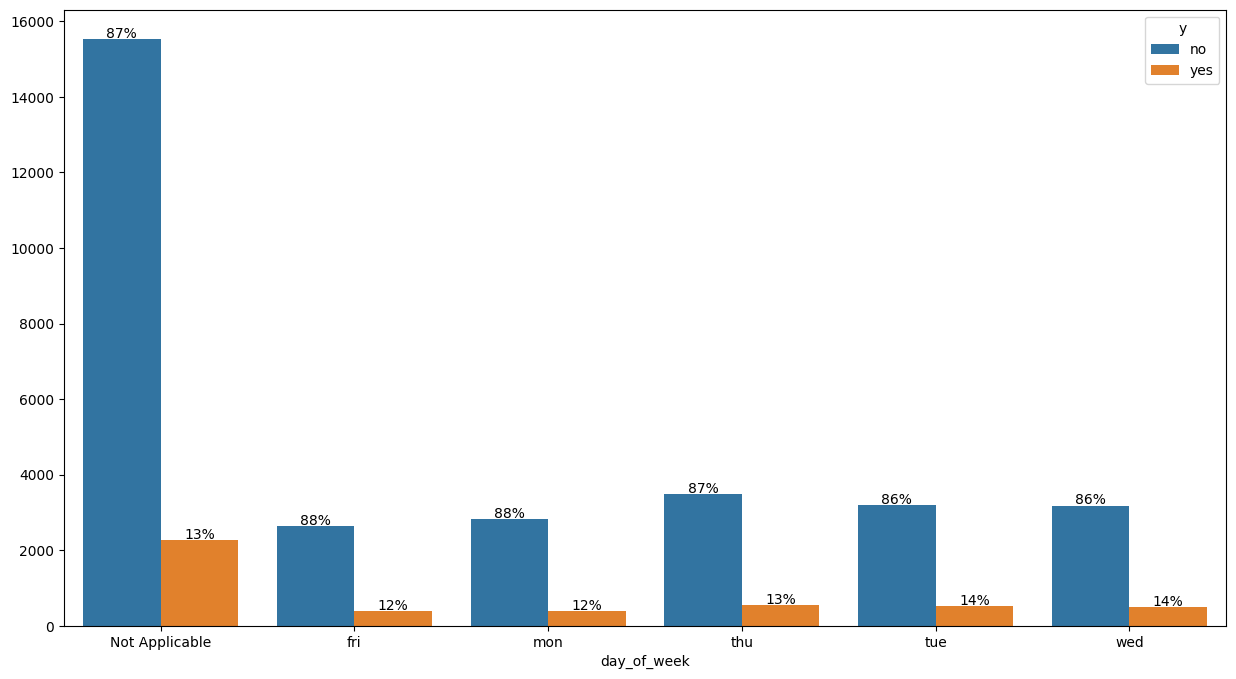

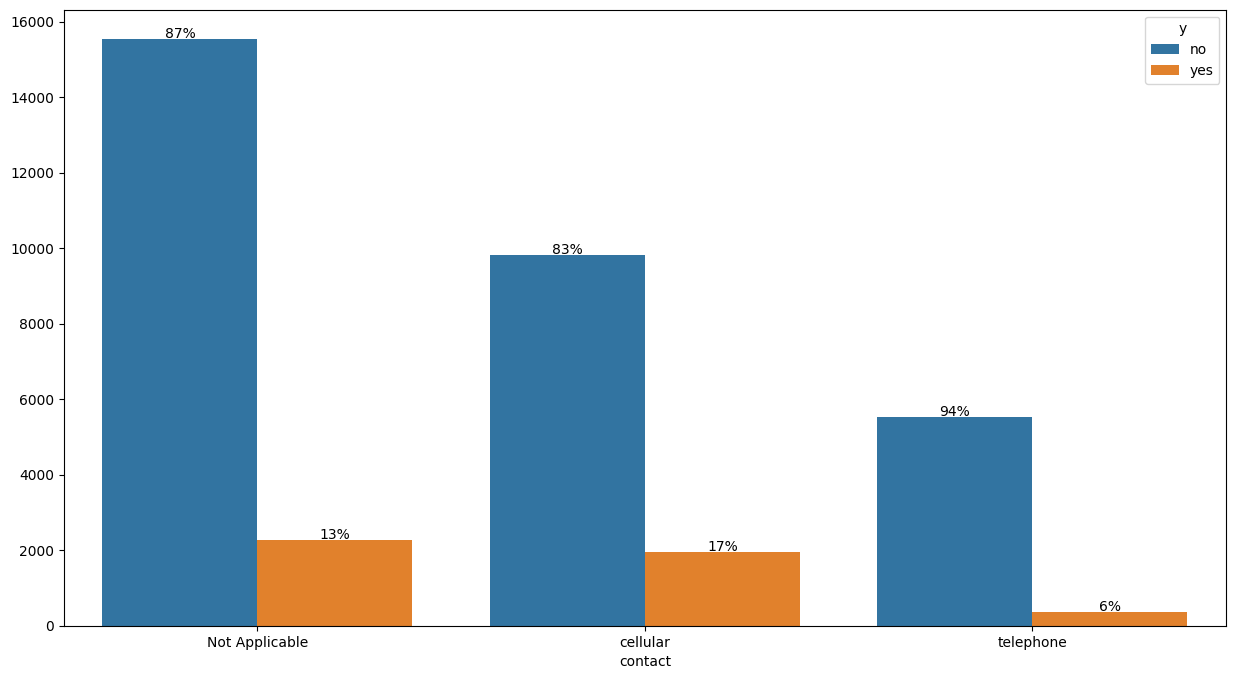

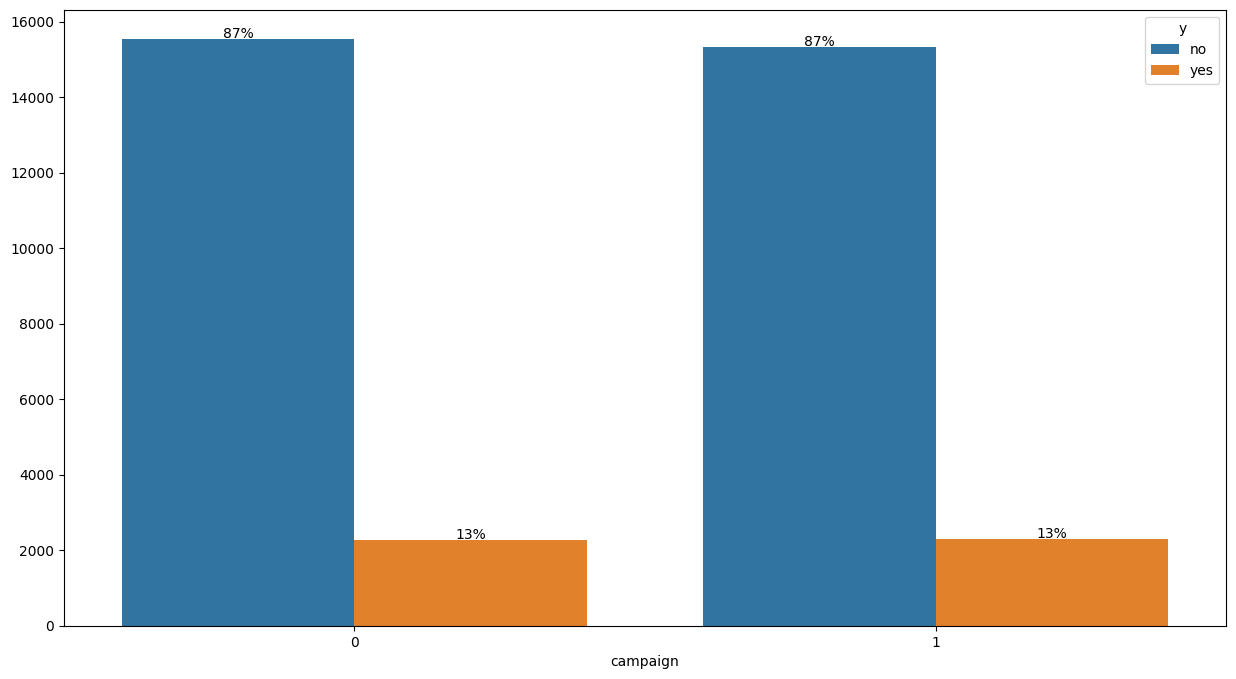

In [ ]:
def countplot(column, dataset,label):
    for index, category in enumerate(column):
        plt.figure(figsize=(15,8))
        order = sorted(dataset[category].unique())
        ax = sns.countplot(x= category, data=dataset, hue=label, order=order)
        ax.set_ylabel('')

        bars = ax.patches
        half = int(len(bars)/2)
        left_bars = bars[:half]
        right_bars = bars[half:]

        for left, right in zip(left_bars, right_bars):
            height_l = left.get_height()
            height_r = right.get_height()
            total = height_l + height_r

            ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
            ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

countplot(cat_features, campaign_data,'y')

Plot boxplot and distribution plots to understand the impact of numercial features on response value.

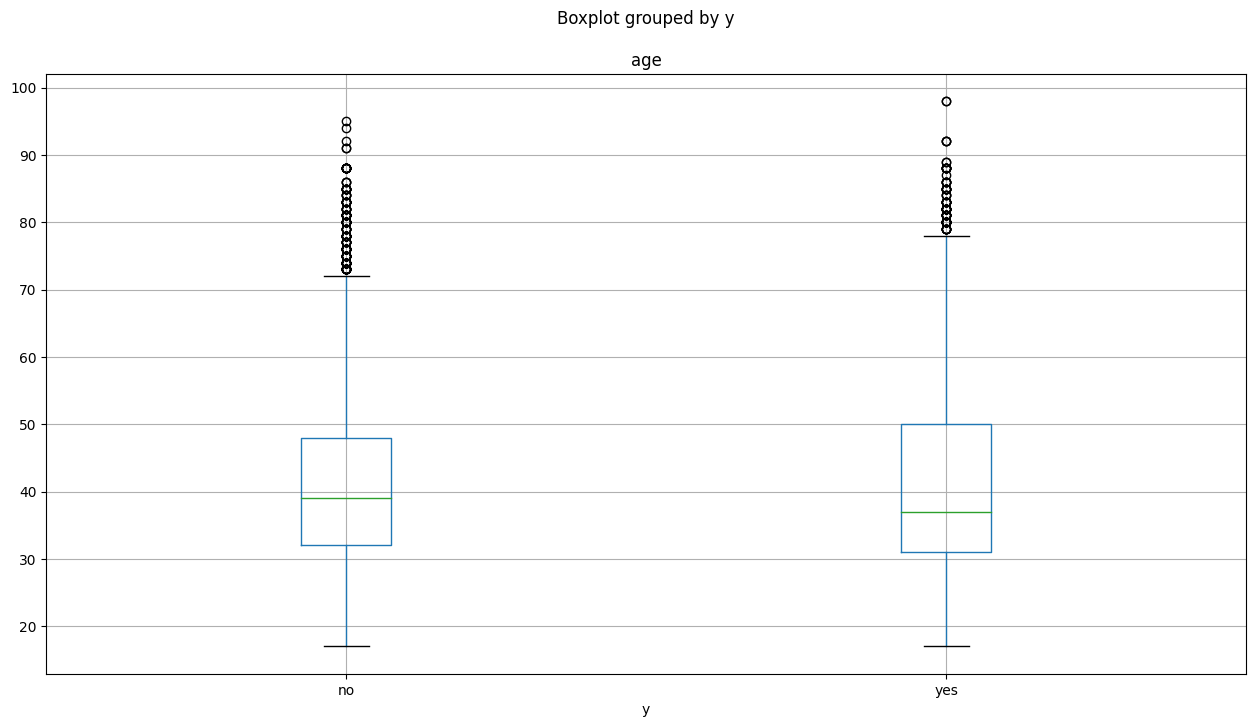

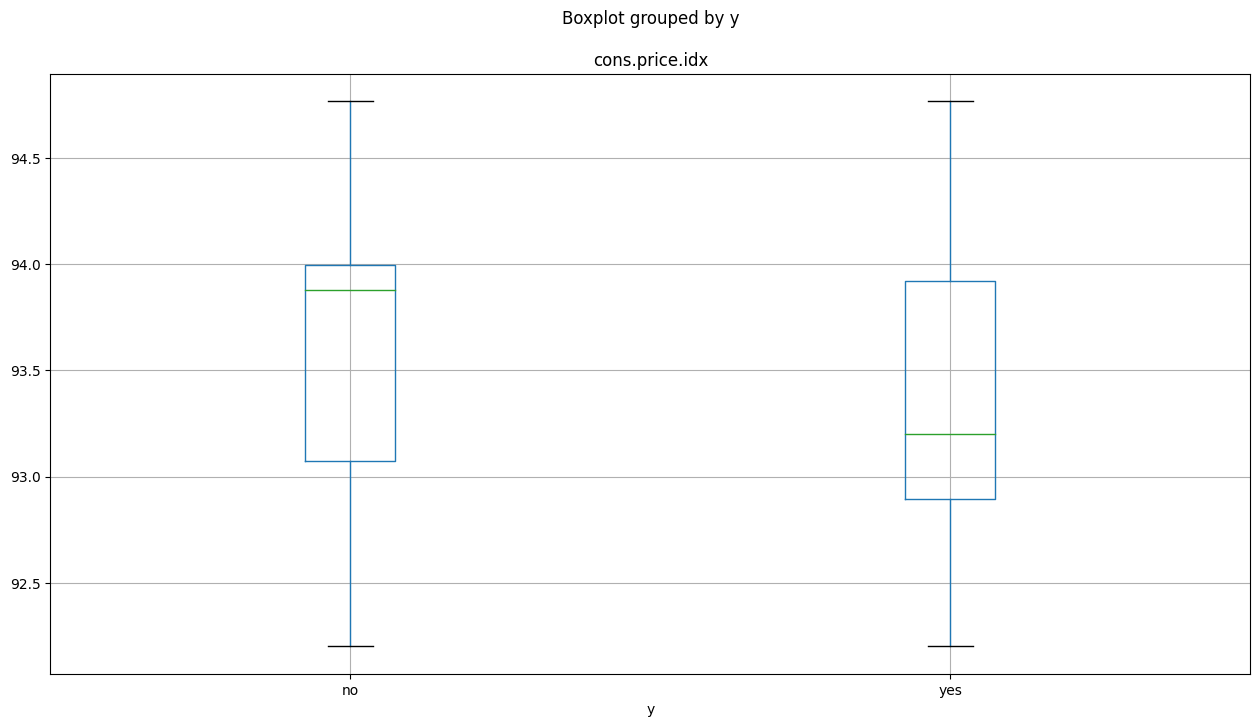

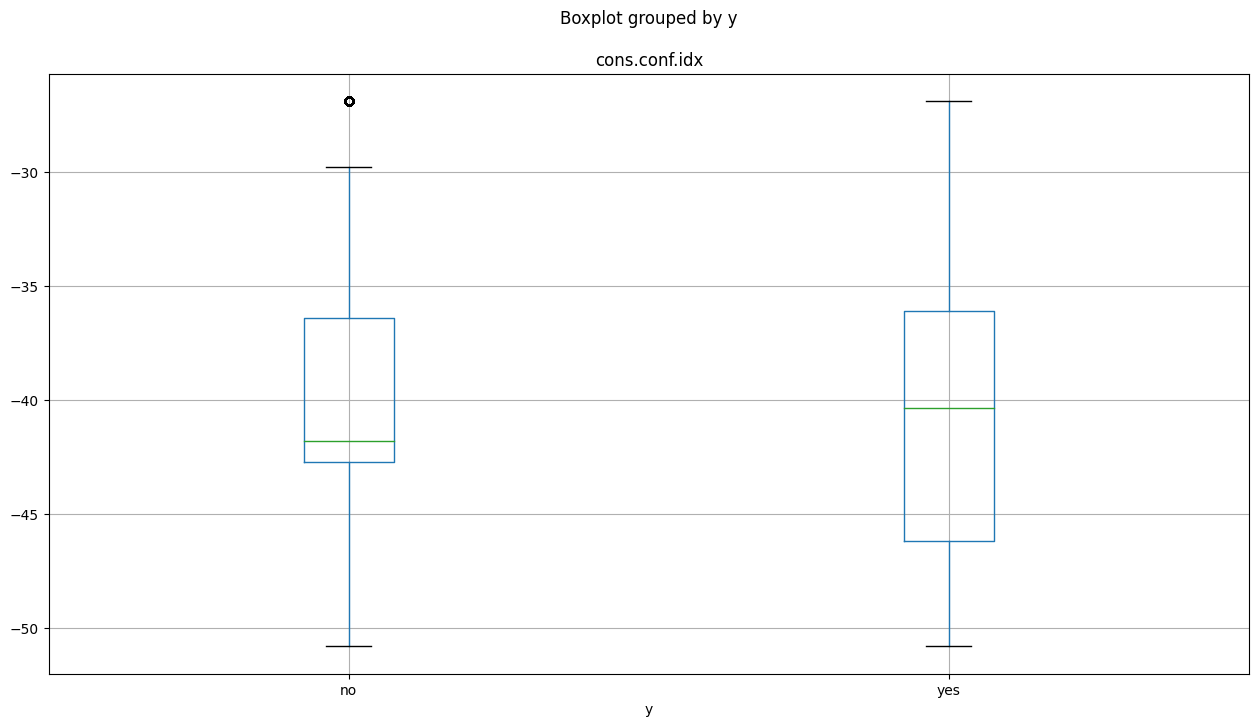

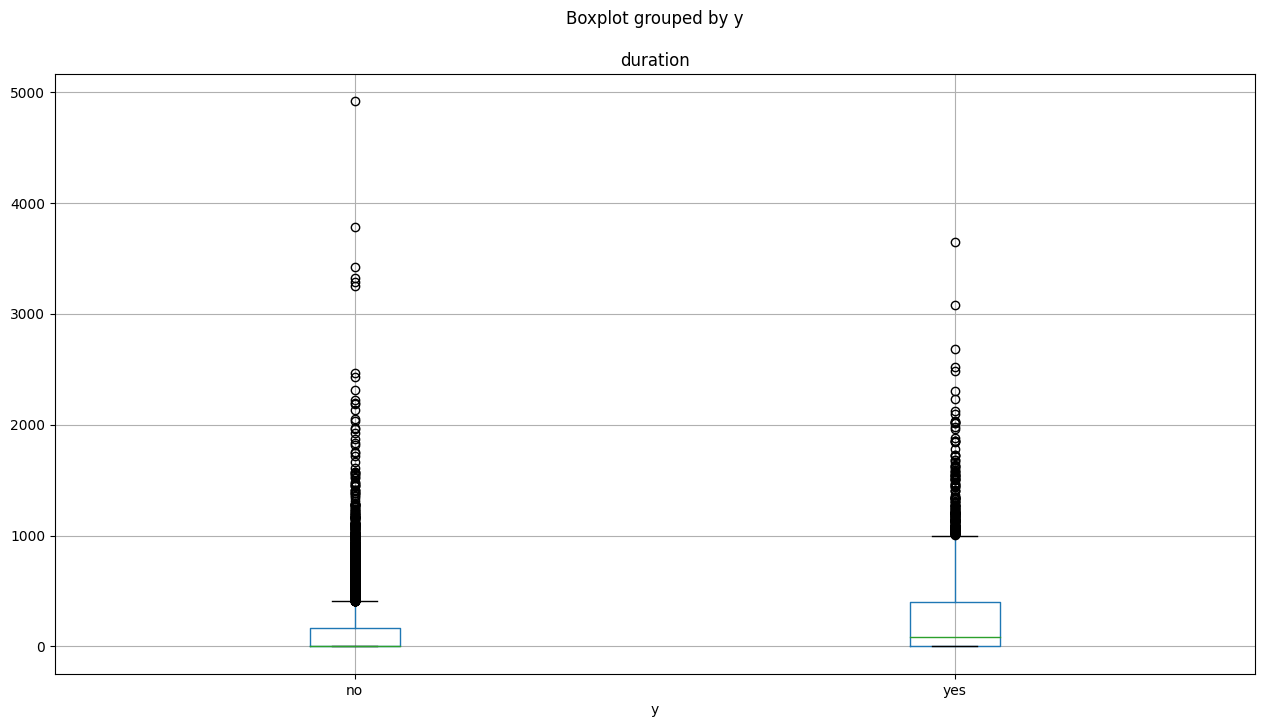

In [ ]:
def boxplot_response(columns,label,dataset):
    for c in columns:
        dataset.boxplot(by=label,figsize=(15,8),column=[c])
boxplot_response(num_features, 'y', campaign_data)

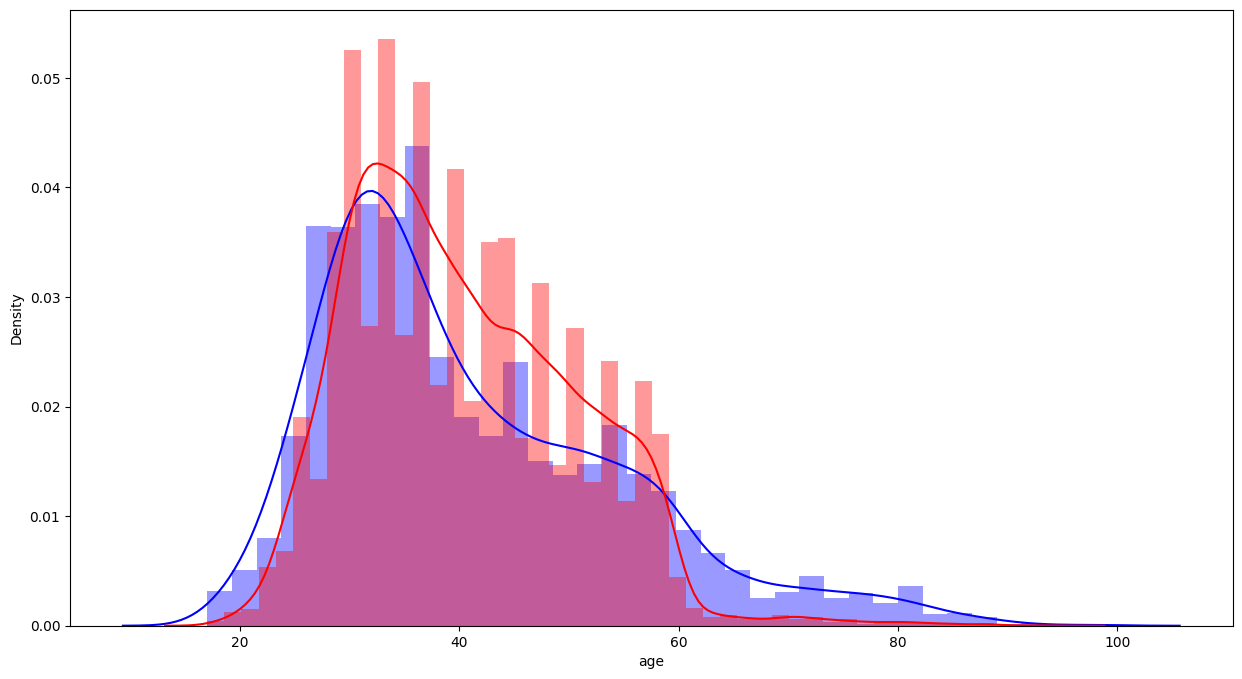

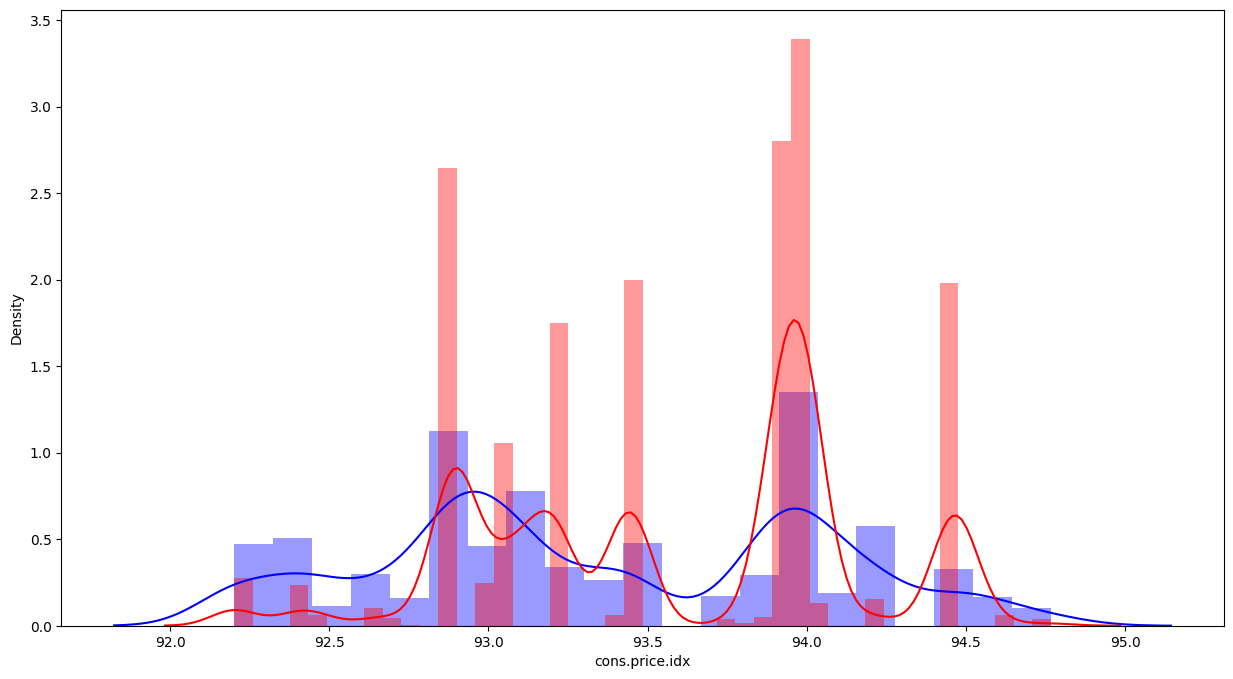

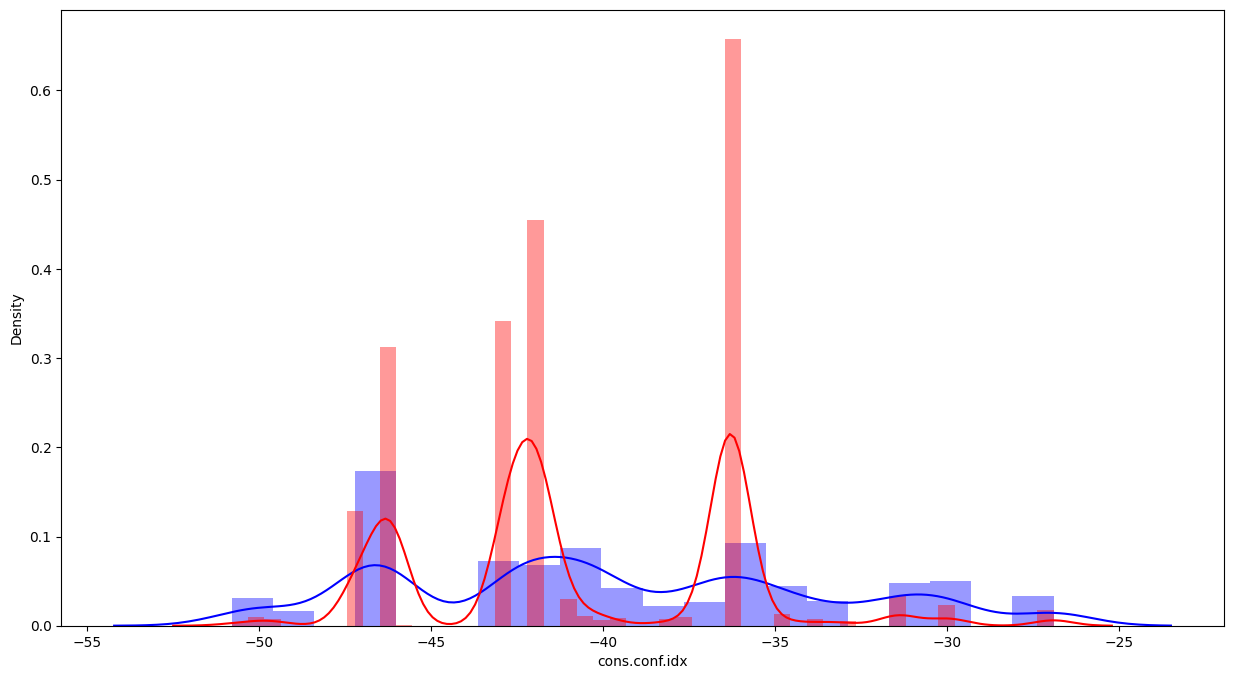

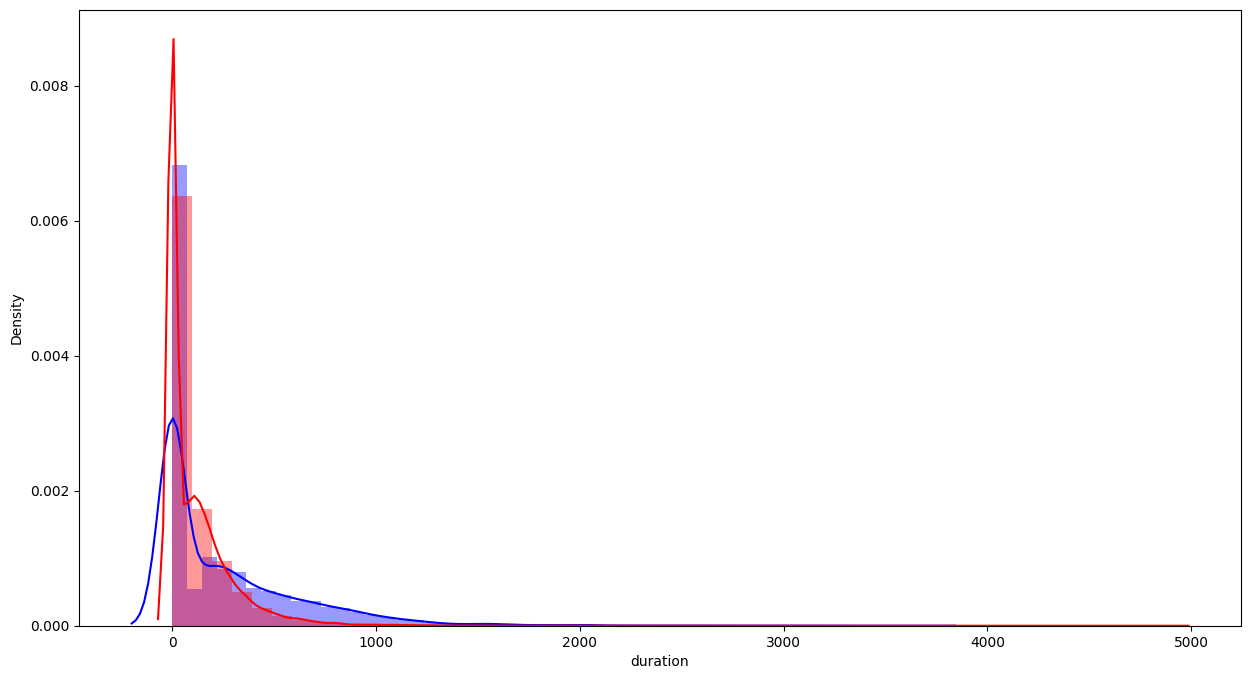

In [ ]:
def dsitplot_response(column, dataset):
    for c in column:
        plt.figure(figsize=(15,8))
        ax = sns.distplot(dataset.loc[(dataset['y']=='yes')][c],color='blue')
        ax = sns.distplot(dataset.loc[(dataset['y']=='no')][c], color='red')
#         plt.show()
dsitplot_response(num_features, campaign_data)

## Feature Engineering
Looking at numerical features, we perform two main transformations:

- Scale the Numerical data to get mean and variance (0,1)
- Power Transformtion on ***Duration*** field to remove skewness.

For categorical features we apply two main transfomration to get more granular features for classification:  
- Ordinal encoder
- One-hot encoder

In [ ]:
df_data = campaign_data.copy(deep=True)
train_data, test_data = train_test_split(df_data, test_size=0.4, random_state=RANDOM_SATE)

In [ ]:
from sklearn.preprocessing import power_transform, StandardScaler

def feature_transform(columns, dataset, method):
    new_features=[]
    scalers = {}
    for c in columns:
        if method == 'pwr':
            dataset[c+'_tfm']=power_transform(dataset[[c]]).reshape(-1,1)
            new_features.append(c+'_tfm')
            scaler = None
        if method == 'std':
            scaler = StandardScaler()
            scaler.fit(dataset[[c]])
            scalers[c]= scaler
            dataset[c+'_scl']= scaler.transform(dataset[[c]]).reshape(-1,1)
            new_features.append(c+'_scl')
    return new_features, scalers, dataset

Fit scaler and power transformer on training data

In [ ]:
num_features_tfm, _ , train_data = feature_transform(['duration'], train_data, 'pwr')
num_features_scl, std_scaler, train_data = feature_transform(num_features, train_data, 'std')

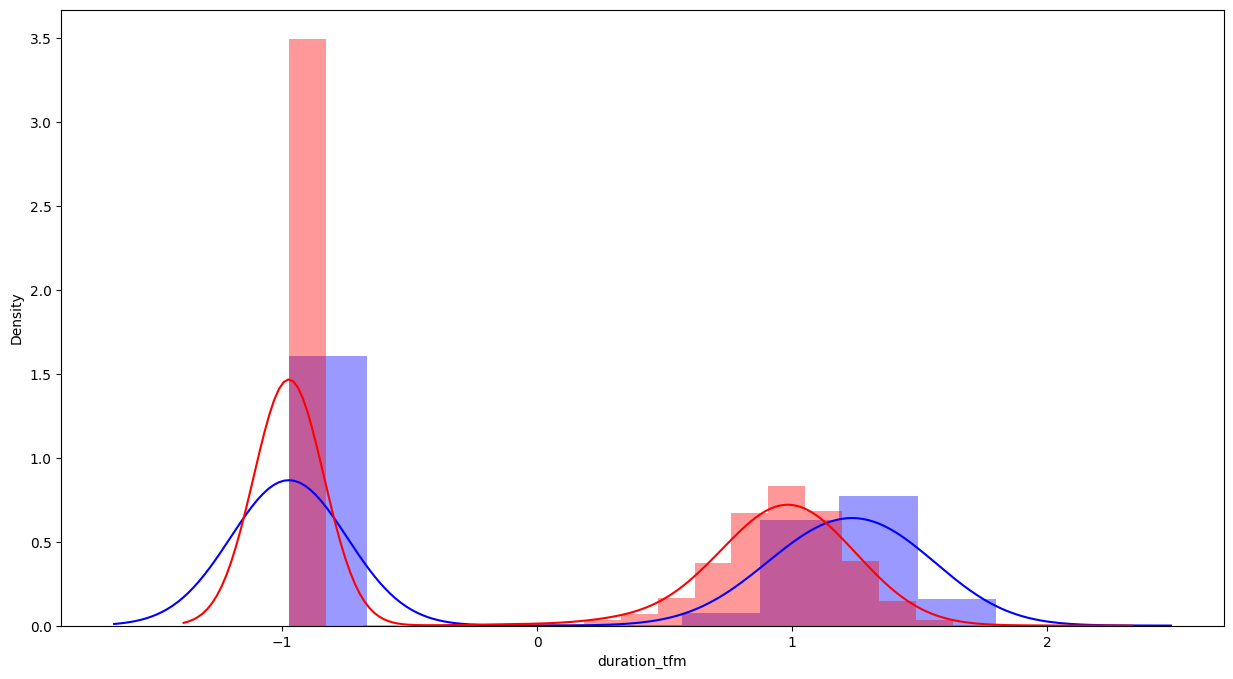

In [ ]:
dsitplot_response(num_features_tfm, train_data)

Apply scaler on test data

In [ ]:
_,_,test_data = feature_transform(['duration'], test_data, 'pwr')
for c in num_features:
    test_data[c+'_scl'] = std_scaler[c].transform(test_data[[c]]).reshape(-1,1)

Fit Ordinal Encoder on training data and apply on test data

In [ ]:
def encoder(dataset, columns):
    # label_encoder = LabelEncoder()
    # dataset['response'] = label_encoder.fit_transform(dataset['y'].to_numpy().reshape(-1,1))
    encoder_models = {}
    new_feature = []
    for c in columns:
        ord_encoder = OrdinalEncoder()
        ord_encoder.fit(dataset[c].to_numpy().reshape(-1,1))
        encoder_models[c]= ord_encoder
        dataset[c+'_int'] = encoder_models[c].transform(dataset[c].to_numpy().reshape(-1,1))
        new_feature.append(c+'_int')
    return encoder_models, new_feature, dataset

encoder_models, int_features, train_data = encoder(train_data, cat_features)
for c in cat_features:
    test_data[c+'_int'] = encoder_models[c].transform(test_data[c].to_numpy().reshape(-1,1))

Apply lable encoder to target variable in traning and test data set

In [ ]:
label_encoder = LabelEncoder()
train_data['response'] = label_encoder.fit_transform(train_data['y'].to_numpy().reshape(-1,1))
# TODO 2: use LabelEncode() function and transform test_data["response"]
# Edit the code by replacing the underscore
test_data['response'] = _____________________

Fit one-hot encoder on traning data and apply on test data

In [ ]:
def oh_encoder(dataset, features):
    ohe_models={}
    new_features=[]
    for c in features:
        oh_encoder=OneHotEncoder(handle_unknown='ignore')
        oh_encoder.fit(dataset[c].to_numpy().reshape(-1,1))
        out = oh_encoder.transform(dataset[c].to_numpy().reshape(-1,1))
        df= pd.DataFrame.sparse.from_spmatrix(out, columns=[c+'_'+n for n in oh_encoder.categories_[0]],)
        dataset = pd.concat([dataset,df.set_index(dataset.index)], axis=1)
        ohe_models[c]=oh_encoder
        new_features.extend([c+'_'+n for n in oh_encoder.categories_[0]])
    return ohe_models, new_features, dataset

In [ ]:
oh_models, oh_features, train_data = oh_encoder(train_data, cat_features)
for c in cat_features:
    out = oh_models[c].transform(test_data[c].to_numpy().reshape(-1,1))
    df= pd.DataFrame.sparse.from_spmatrix(out, columns=[c+'_'+n for n in oh_models[c].categories_[0]],)
    test_data = pd.concat([test_data,df.set_index(test_data.index)], axis=1)

## 2-Dimension Visulisation
It is tempting to use TSEN to see how transformed features perform in regards to response value on 2 dimensional space.

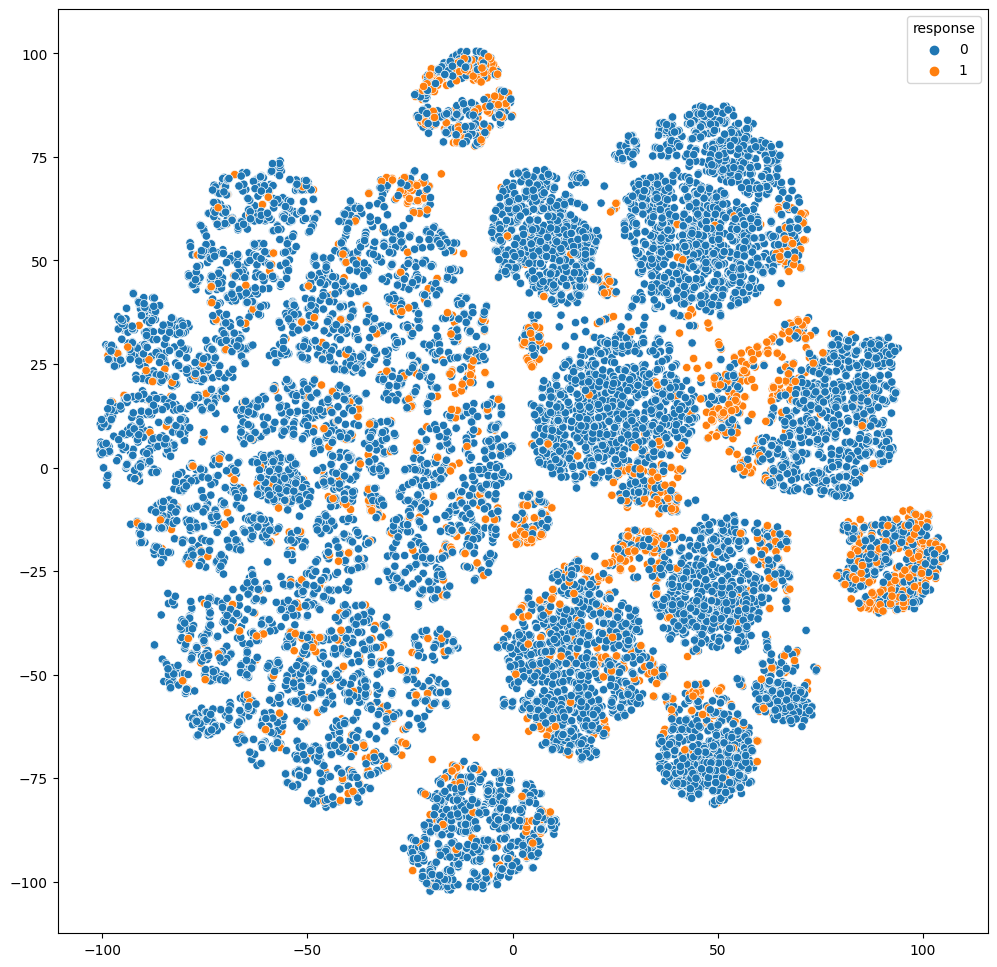

In [ ]:
tsne_model = TSNE(n_components=2,random_state=RANDOM_SATE, perplexity=30)
tnse_data = tsne_model.fit_transform(train_data[num_features_scl+
                                                num_features_tfm+
                                                oh_features])
plt.figure(figsize=(12,12))
sns.scatterplot(x=tnse_data[:,0], y=tnse_data[:,1], hue=train_data['response'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

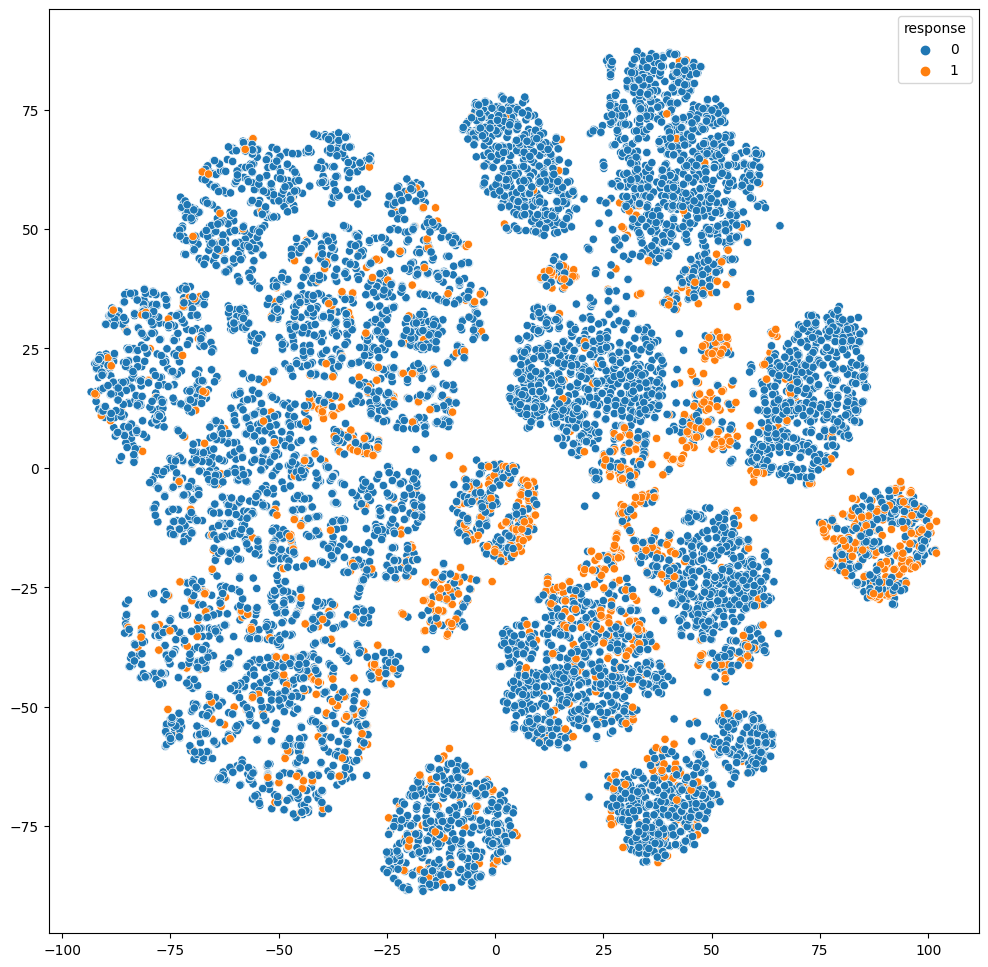

In [ ]:
tsne_model = TSNE(n_components=2,random_state=RANDOM_SATE, perplexity=30)
tnse_data = tsne_model.fit_transform(test_data[num_features_scl+
                                                num_features_tfm+
                                                oh_features])
plt.figure(figsize=(12,12))
sns.scatterplot(x=tnse_data[:,0], y=tnse_data[:,1], hue=test_data['response'])
plt.show

## Feature Selection
### Univariate Feature Selection:
The feature selection is carried out using two following methods on categorical features to select top 10 significant predictors:  
- Chi2
- f_classif

In [ ]:
# TODO: Tech Focus Only:
# Add one or two other feature selection methods and present the feature importance

In [ ]:
def feature_selection_univariate(features, dataset, method, label,top_k):
    fselect_model = SelectKBest(method,k='all').fit(dataset[features],dataset[label])
    importances = fselect_model.scores_
    indices = np.argsort(importances)[-top_k:]
    selected_features =[features[i] for i in reversed(indices)]
    return fselect_model, selected_features

def plot_feature_importance(fselect_model, features):
    importances = fselect_model.scores_
    p_value = fselect_model.pvalues_
    indices = np.argsort(importances)[-10:]
    plt.figure(figsize=(15,8))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    for i, v in enumerate(indices):
        plt.text(importances[v]+3, i, str(p_value[v]), color='black', fontweight='bold')
    plt.show()

In [ ]:
features = int_features + oh_features
fselect_model_f_classif, selected_features_f_classif = feature_selection_univariate(
    features, train_data,f_classif,'response',10)
fselect_model_chi2, selected_features_chi2, = feature_selection_univariate(
    features, train_data,chi2,'response',10)

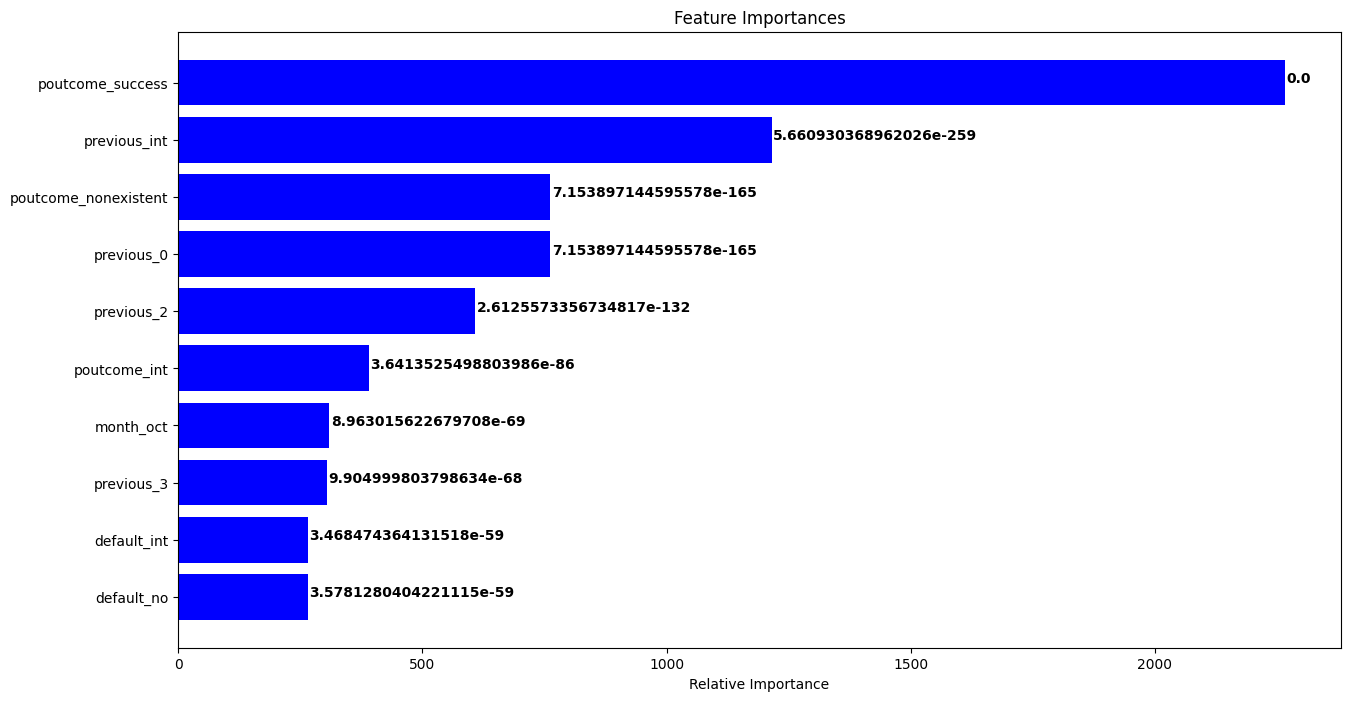

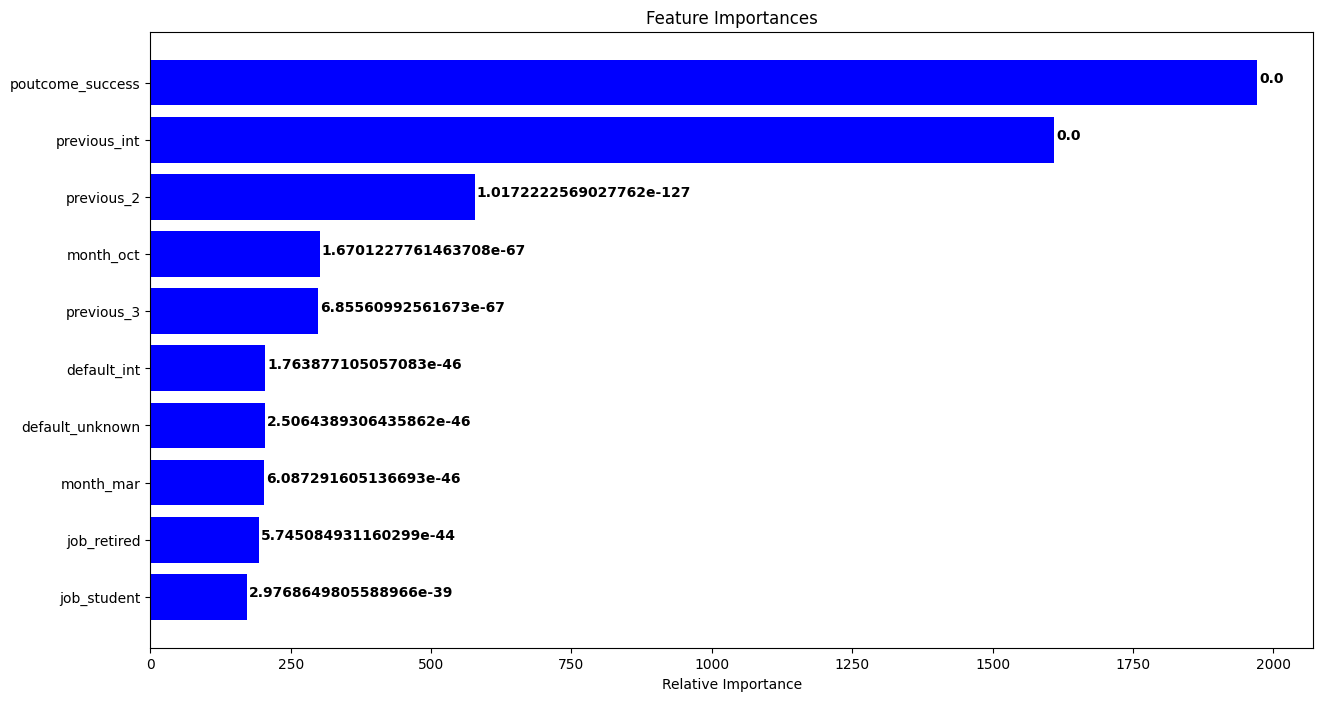

In [ ]:
plot_feature_importance(fselect_model_f_classif, features)
plot_feature_importance(fselect_model_chi2, features)

As It can bee seen, all top 10 selected features by two methods are significantly (**p-value less than 0.01**) contribute to response value prediction.

### ML Model Feature Selection
Carry out feature selection using ML models, that provide feature importance. Also plot the correlation among selected features to make sure there is no high correlation among features. The models used for feature selection are as below:
- Random Forest Classifier
- XgBoost Classifier
- Logistic Regression Classifier

In [ ]:
def feature_selection_model(dataset, features, label, model, k):
    X = np.asarray(dataset[features])
    y = np.asarray(dataset[label])
    if model=='RF':
        clf = RandomForestClassifier(n_estimators=50,
                                     class_weight='balanced',
                                     random_state=RANDOM_SATE,
                                     n_jobs=8)
    elif model=='GB':
        clf = XGBClassifier(n_estimators=50,
                            scale_pos_weight=87,
                            random_state=RANDOM_SATE,
                            n_jobs=8)
    elif model =='LR':
        clf = LogisticRegression(C=1000,
                                 class_weight='balanced',
                                 max_iter=10000,
                                 n_jobs=8)
    else :
        print('please prvide proper model such as RF or GB or LR ')
    rfe = RFE(clf, n_features_to_select=k)
    rfe_model = rfe.fit(X, y)
    feature_list = {}
    for i, v in zip(features, rfe_model.ranking_):
        feature_list[i]=v
    selected_features = {k:v for k,v in feature_list.items() if v<=1}
    return selected_features

{'duration_tfm': 1, 'age_scl': 1, 'cons.price.idx_scl': 1, 'cons.conf.idx_scl': 1, 'duration_scl': 1, 'job_int': 1, 'education_int': 1, 'poutcome_int': 1, 'month_int': 1, 'poutcome_success': 1}


<Axes: >

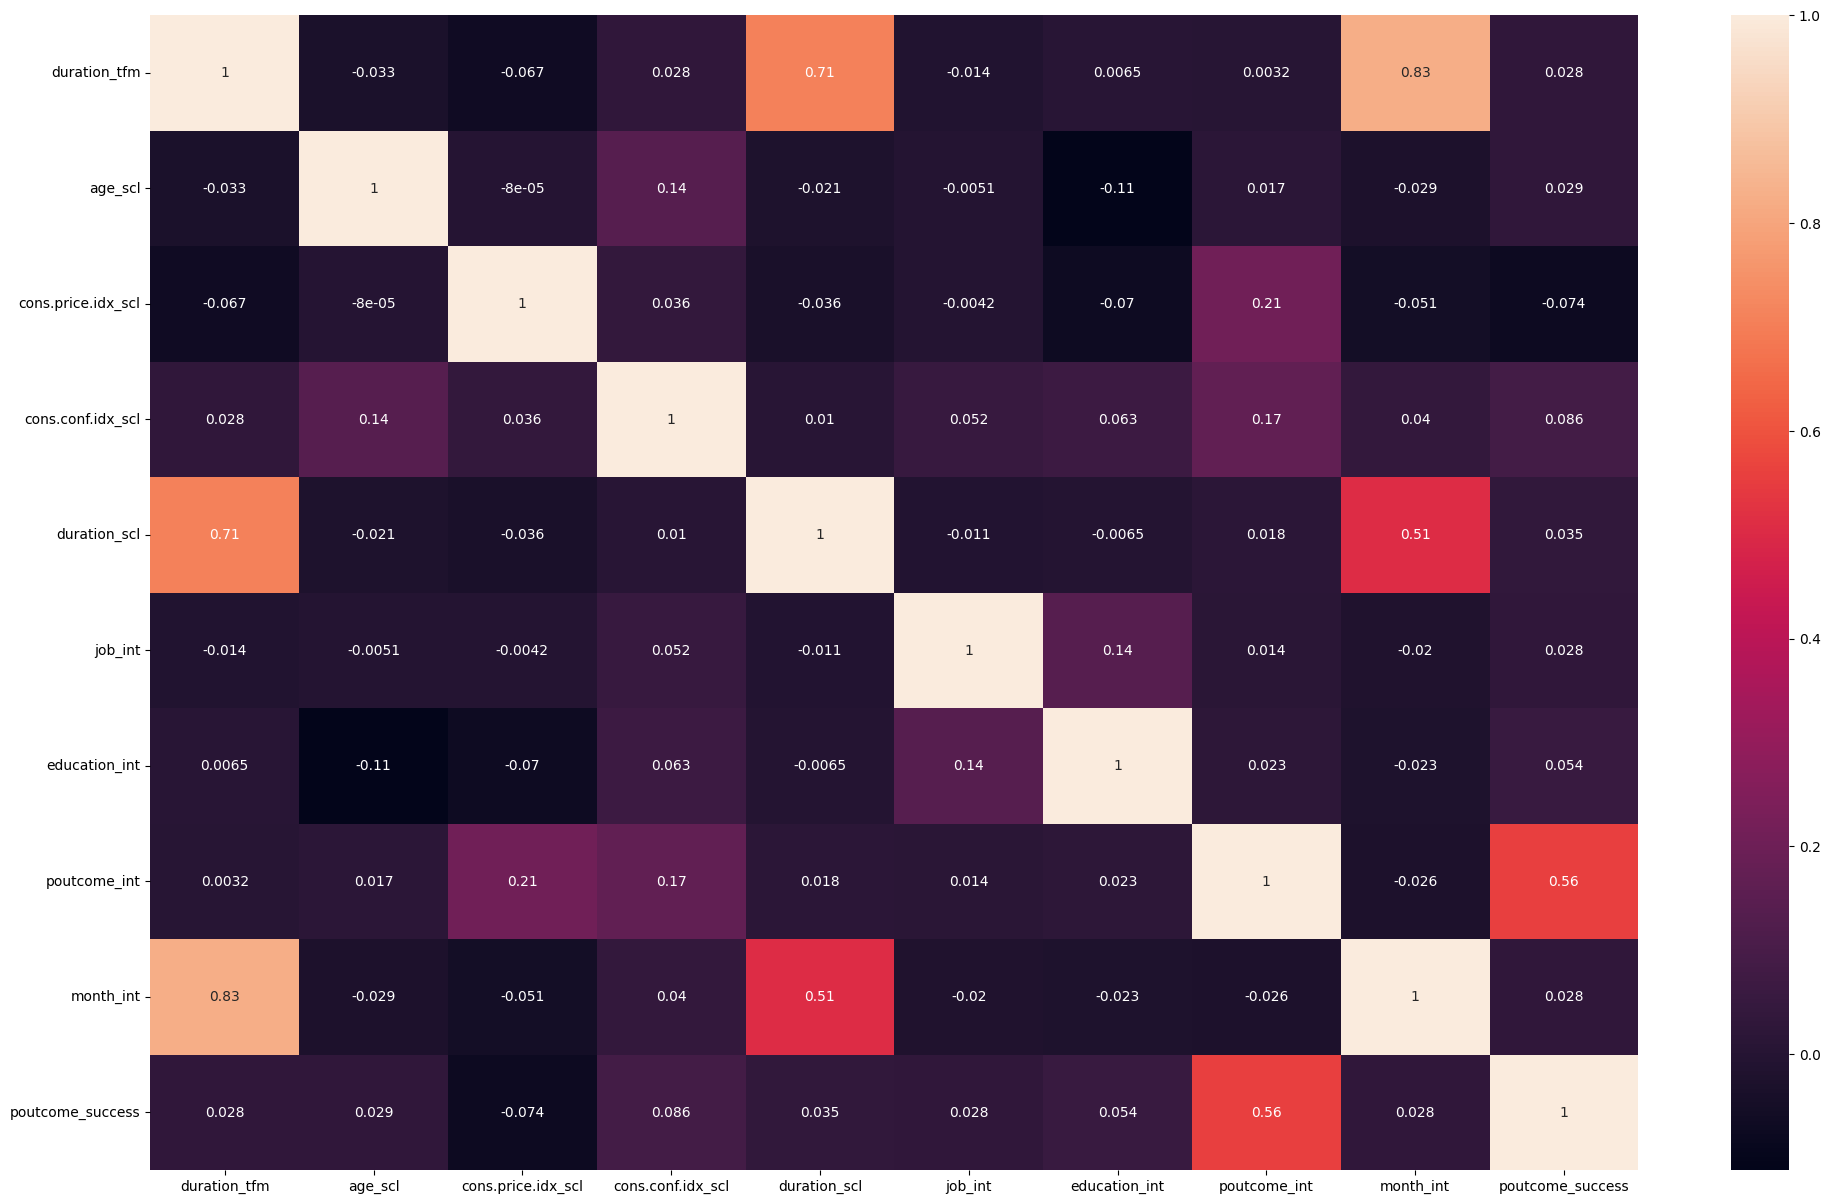

In [ ]:
selected_feature_RF = feature_selection_model(dataset=train_data,
                   features=num_features_tfm+num_features_scl+int_features+oh_features,
                   label='response',
                   model='RF',
                   k=10)
print(selected_feature_RF)
plt.figure(figsize=(24,15))
sns.heatmap(train_data[selected_feature_RF].corr(), annot=True)

In [ ]:
# TODO 3: run featuer selection using feature_selection_model() and logistic Regresion ('LR')
#[Similar to above code block that used Random Forest ('RF')]
# Edit the code by replacing the underscore

{'duration_tfm': 1, 'campaign_int': 1, 'default_yes': 1, 'poutcome_success': 1, 'previous_7': 1, 'month_mar': 1, 'month_oct': 1, 'contact_Not Applicable': 1, 'campaign_0': 1, 'campaign_1': 1}


<Axes: >

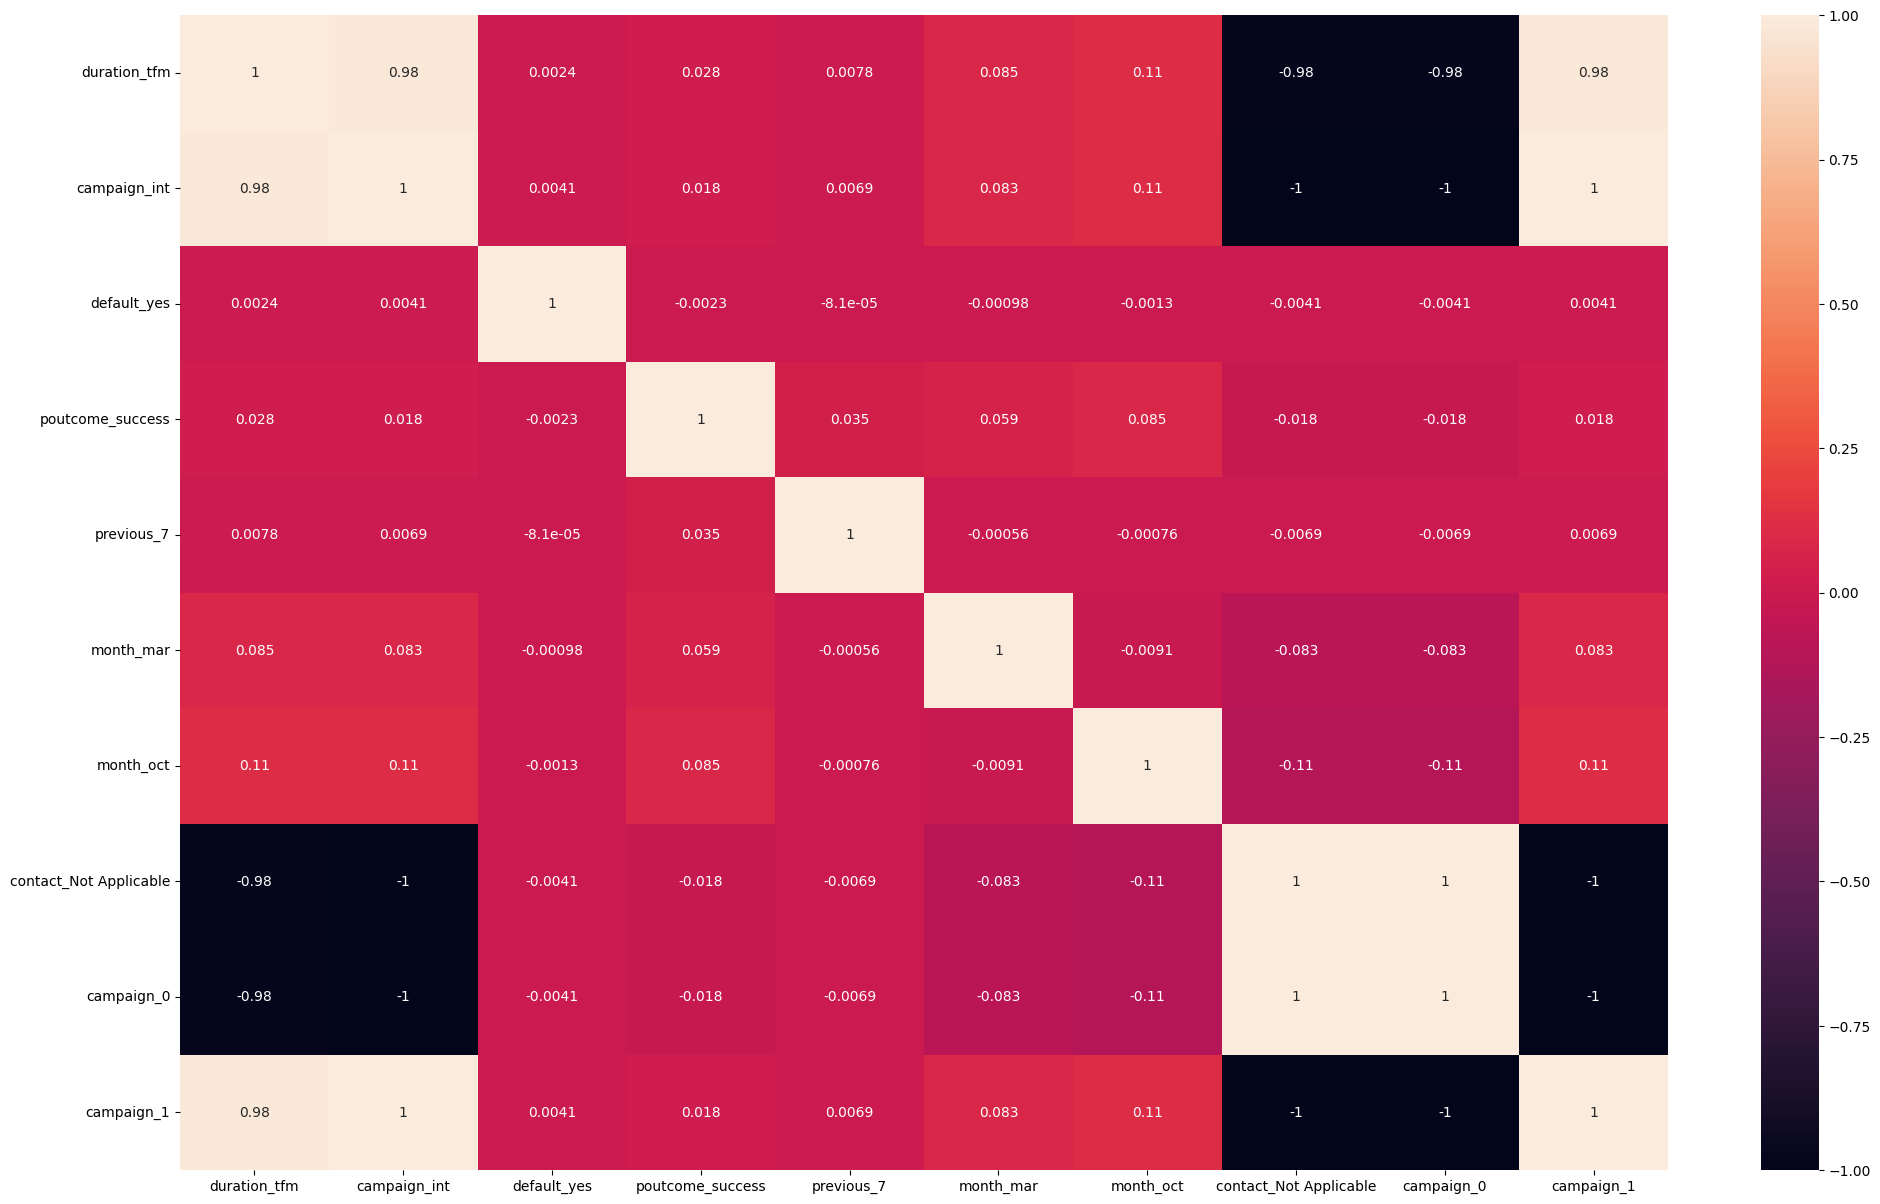

In [ ]:
selected_feature_LR = feature_selection_model(dataset=train_data,
                   features=num_features_tfm+num_features_scl+int_features+oh_features,
                   label=_______,
                   model=_____,
                   k=____)
print(selected_feature_LR)
plt.figure(figsize=(24,15))
sns.heatmap(train_data[selected_feature_LR].corr(), annot=True)

In [ ]:
# TODO: Tech Focus Only:
# Evaluate the selected features from previous methods (univariate and model selected) and propose which
# features should be used in traning.

It is assumed the features selected by RF provides better results.Hence we run modelling with these selected features and compare results on test data. RF and XGB are used for modelling because they are capable of handling complex patterns.Also, they have class imbalanced weighting mechanism that can be good choice to handle imbalanced problems.

In [ ]:
def modeling(train_data, test_data, selected_faeture):
    rf_parameters = {'max_depth':[5],
                     'criterion':['gini'] ,
                     'n_estimators':[100]}
    gb_parameters = {'learning_rate':[0.01],
                     'n_estimators':[100],
                     'max_depth':[5],
                     'colsample_bytree':[0.1],
                     'subsample':[0.1]}

    rf = RandomForestClassifier(random_state=RANDOM_SATE,
                                n_jobs=8,
                                class_weight='balanced')

    gb = XGBClassifier(random_state=RANDOM_SATE,
                       n_jobs=8,
                       scale_pos_weight=87)

    clf_rf = GridSearchCV(estimator=rf,
                          param_grid=rf_parameters,
                          scoring='roc_auc',
                          n_jobs=8,
                          verbose=10,
                          cv=5)
    clf_gb = RandomizedSearchCV(estimator=gb,
                                param_distributions=gb_parameters,
                                scoring='roc_auc',
                                n_iter=20,
                                n_jobs=8,
                                verbose=10,
                                cv=5)

    model_rf = clf_rf.fit(train_data[selected_faeture], train_data['response'])
    model_gb = clf_gb.fit(train_data[selected_faeture], train_data['response'])

    auc_score={}
    auc_score['rf'] = roc_auc_score(test_data['response'], model_rf.best_estimator_.predict(test_data[selected_faeture]))
    auc_score['gb'] = roc_auc_score(test_data['response'], model_gb.best_estimator_.predict(test_data[selected_faeture]))
    return model_rf, model_gb, auc_score

In [ ]:
rf, gb, auc_score = modeling(train_data, test_data, selected_feature_RF)
auc_score

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'rf': 0.7353483836367084, 'gb': 0.5}

In [ ]:
# TODO: Tech Focus Only:
# Add more hyperparameters to above models and iterate to see how the models behaviour
# and select the btter model.

As It can be seen from above, the RF has better performance than XGB. Hence we take RF model and feature set selcted by RF in the final pipeline.

## Fianl Pipeline
Put all data preprocesing and modelling in one pipeline leveraging sklearn pipline. The pipeline includes:
- Power Transformation
- Standard Scaling
- One_Hot Encoding
- Recursive Feature Elimination
- Random Forest Training through Cross Folder Validation

In [ ]:
cat_features=['job', 'marital', 'education', 'default', 'housing','loan',
              'poutcome','previous','month','day_of_week','contact','campaign']
num_features=['age','cons.price.idx', 'cons.conf.idx','duration']

In [ ]:
df_data = campaign_data.copy(deep=True)
train_data, test_data = train_test_split(df_data, test_size=0.4, random_state=RANDOM_SATE)

*** It may take a bit of time ***

In [ ]:
from sklearn.compose import ColumnTransformer
num_transformer = Pipeline(steps=[('power',PowerTransformer())])
num_scaler = Pipeline(steps=[('scaler', StandardScaler())])
cat_encoder = Pipeline(steps=[('order', OrdinalEncoder()),
                              ('ohe',OneHotEncoder(handle_unknown='ignore'))])
prep = ColumnTransformer(
            transformers=[('dur', num_transformer,['duration']),
                          ('scaler',num_scaler,['age','cons.price.idx', 'cons.conf.idx','duration']),
                          ('encoder',cat_encoder, cat_features)
                         ]
                        )

clf = RandomForestClassifier(n_estimators=50,
                             class_weight='balanced',
                             random_state=123,
                             n_jobs=8)
rfe = RFE(clf,n_features_to_select=10)

# TODO: add more hyper parameter valus for max_depth and n_estimators
# Edit the code by replacing the underscore

rf_parameters = {'max_depth':[3,5,___],
                 'criterion':['gini', 'entropy'] ,
                 'n_estimators':[100,200,___]
                }
rf = RandomForestClassifier(class_weight='balanced',
                            random_state=RANDOM_SATE,
                            n_jobs=8)
clf_cv = GridSearchCV(estimator=rf,
                      param_grid=rf_parameters,
                      scoring='roc_auc',
                      n_jobs=8,
                      verbose=10,
                      cv=5)

pipe= Pipeline(steps=[('prep',prep),
                      ('rfe' ,rfe),
                      ('clf' ,clf_cv)
                     ])

ml_pipe = pipe.fit(X=train_data, y=train_data['y'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
dump(ml_pipe, 'ml_pipe.joblib')
print("AUC of model on Traning Data: "+ str(ml_pipe.score(X=train_data, y=train_data['y'])))
print("AUC of model on Test Data: "+ str(ml_pipe.score(X=test_data,   y=test_data['y'])))

AUC of model on Traning Data: 0.8431855326034238
AUC of model on Test Data: 0.8453910547031147


In [ ]:
# TODO: Tech Focus Only:
# Try other metrics than 'roc_auc'in the pipeline and compare the results

## Scoring Customers
Transform the feature "Duration" and Create 11 Buckets for duration


In [ ]:
duration_df = pd.DataFrame()
duration_df['duration'] = train_data['duration']
duration_df['tfm_duration']=PowerTransformer().fit_transform(train_data['duration'].to_numpy().reshape(-1,1))
duration_df['buk_duration']=KBinsDiscretizer(n_bins=11,
                                             encode='ordinal',
                                             strategy='uniform').fit_transform(duration_df['tfm_duration'].to_numpy().reshape(-1,1))
duration = dict(duration_df.groupby(['buk_duration'])['duration'].mean().round())
print(duration)

{0.0: 0.0, 1.0: 1.0, 2.0: 5.0, 3.0: 8.0, 4.0: 19.0, 5.0: 41.0, 6.0: 88.0, 7.0: 188.0, 8.0: 416.0, 9.0: 936.0, 10.0: 2474.0}


Calculate the probablity of positive response given the duration is in each of those duration buckets and finally compute the Score for a sample of customers

In [ ]:
sample_customer = pd.DataFrame()
sample_customer = test_data.sample(n=200, random_state=143)
sample_customer['original_duration']= sample_customer['duration']
for k, v in duration.items():
    sample_customer['duration']= duration[k]
    sample_customer['pr'+str(int(k))]= ml_pipe.predict_proba(X=sample_customer)[:,1]

sample_customer['score'] = sum([200*sample_customer['pr'+str(int(k))] if k==0 else
                                (100-k*2)*sample_customer['pr'+str(int(k))]
                                for k, v in duration.items()])/11

In [ ]:
sample_customer.sort_values(["score"], ascending=False)

## Cluster Analysis (Optional)
We do brief cluster analysis using selected features to gain any useful insight about the customers and their pattens in different clusters. We would like to see if We can segment customers in meaningful way.  

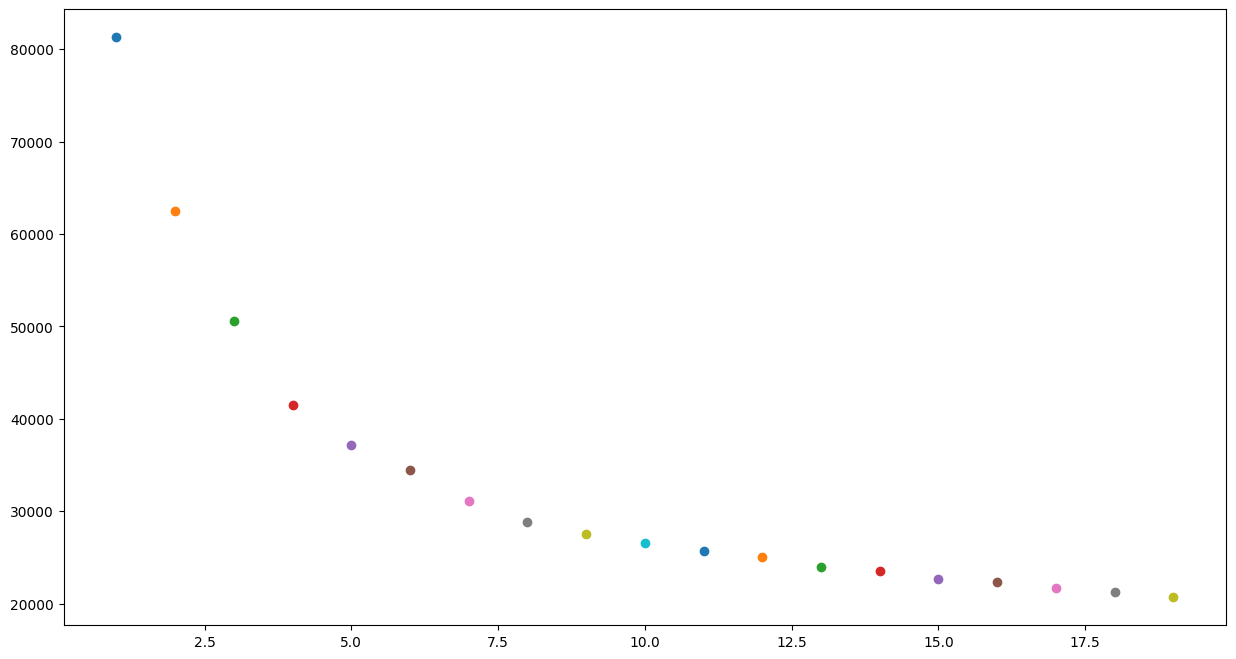

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
cluster_data = train_data.copy(deep=True)
rss = {}

for k in range(1,20):
    kmeans = KMeans(n_clusters=k).fit(
        ml_pipe.steps[1][1].transform(ml_pipe.steps[0][1].transform(train_data))[:,(1,2,3,5,6,7,8,9)]
    )
    rss[k] = kmeans.inertia_
plt.figure(figsize=(15,8))
for k in rss:
    plt.scatter(int(k), rss[k])
plt.savefig('test.png')

In [ ]:
cluster_data['cluster'] = KMeans(n_clusters=8).fit_predict(
    ml_pipe.steps[1][1].transform(ml_pipe.steps[0][1].transform(cluster_data)))
cluster_data.to_csv('cluster_data.csv')

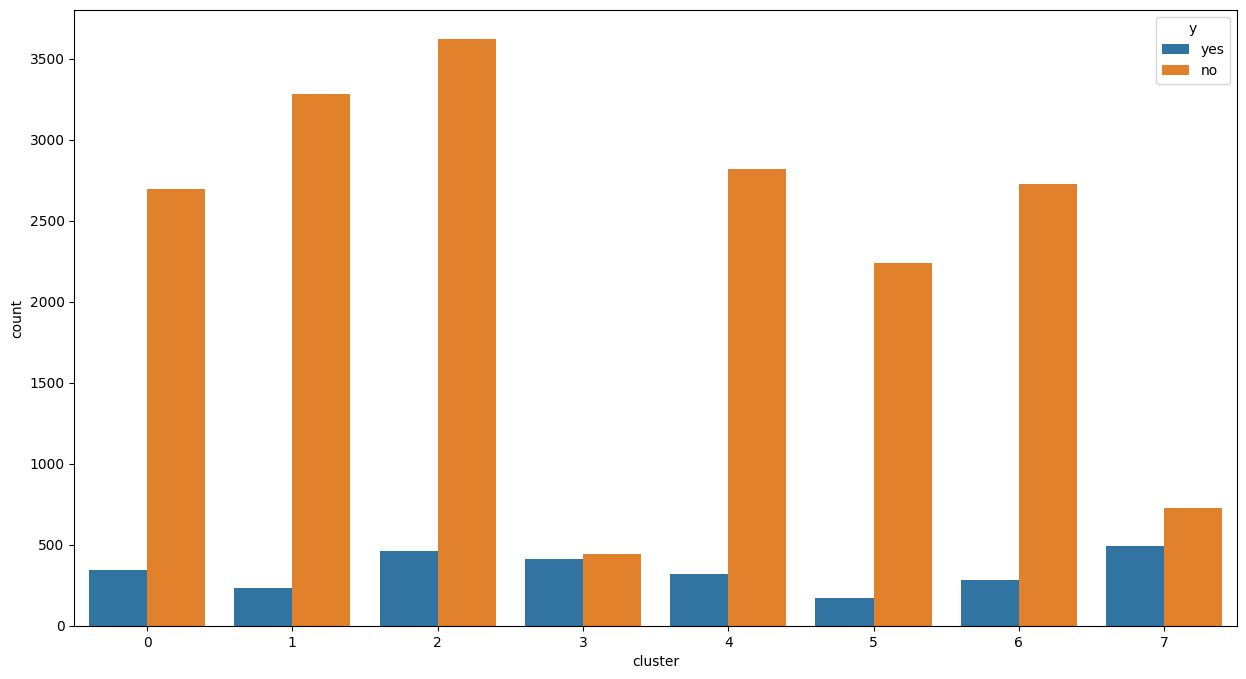

In [ ]:
con = (cluster_data['campaign']=='1')
plt.figure(figsize=(15,8))
ax = sns.countplot(x="cluster", hue="y", data=cluster_data)

<Axes: xlabel='cluster', ylabel='cons.conf.idx'>

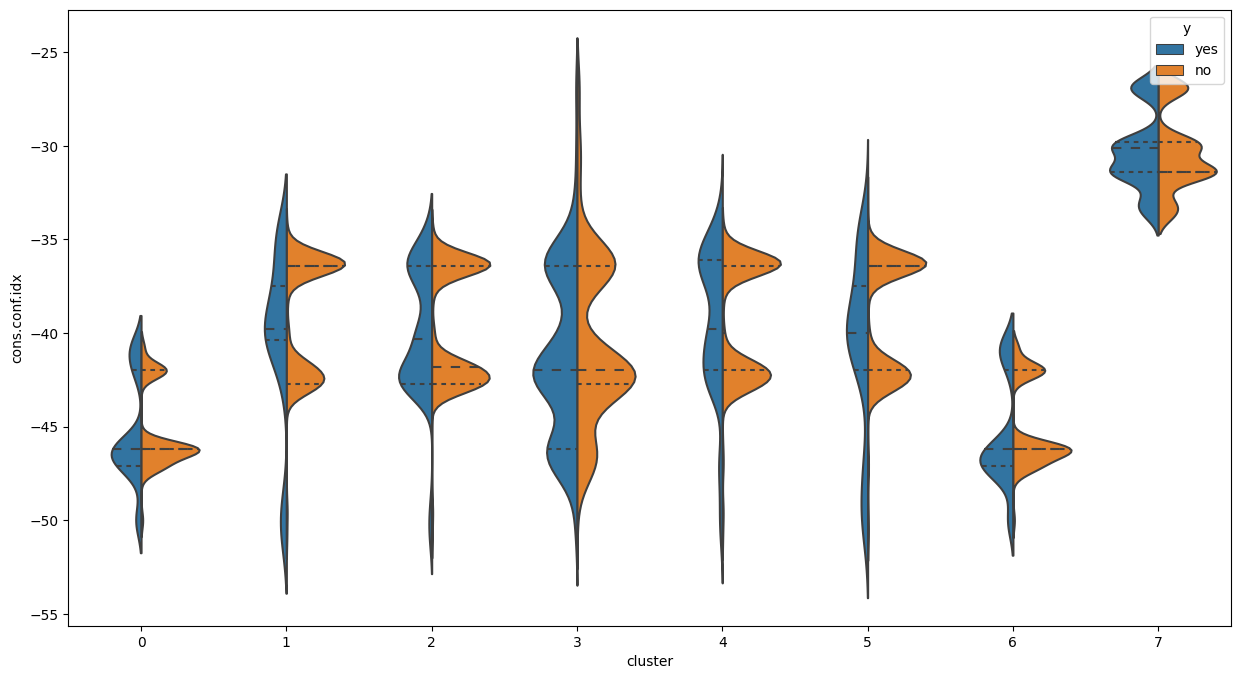

In [ ]:
plt.figure(figsize=(15,8))
sns.violinplot(data=cluster_data, x="cluster", y="cons.conf.idx",hue='y',split=True, inner="quart")

<Axes: xlabel='cluster', ylabel='cons.price.idx'>

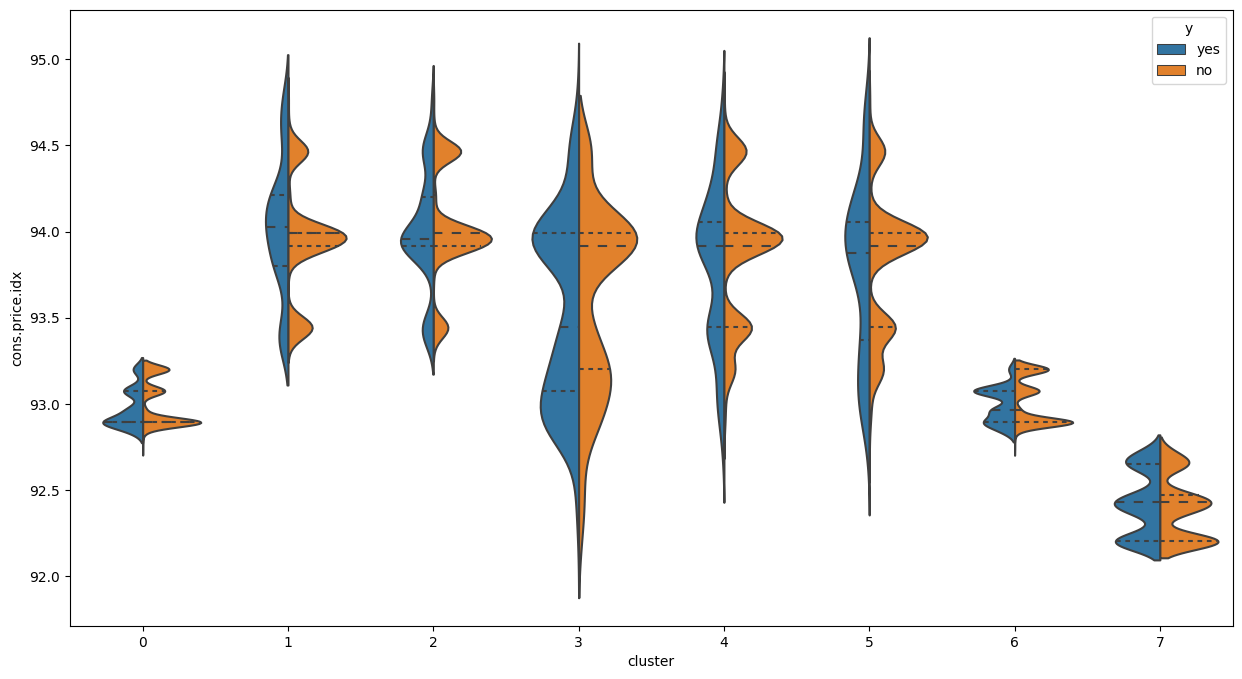

In [ ]:
plt.figure(figsize=(15,8))
sns.violinplot(data=cluster_data, x="cluster", y="cons.price.idx",hue='y',split=True, inner="quart")

<Axes: xlabel='cluster', ylabel='age'>

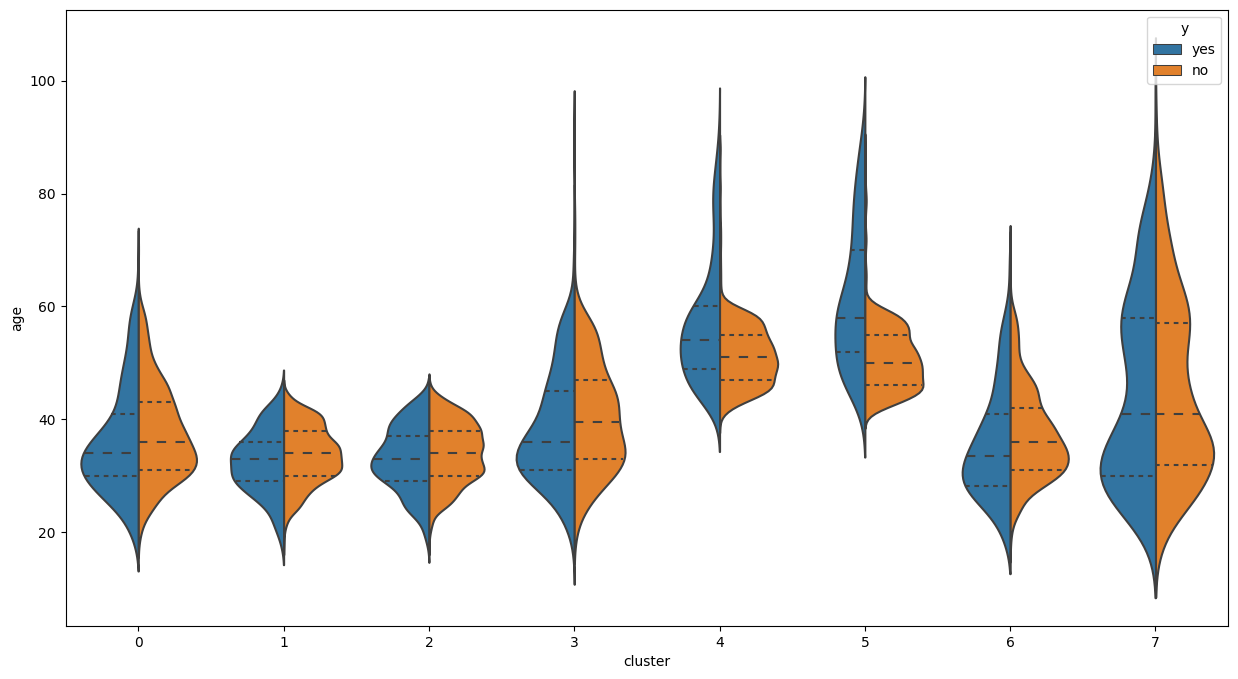

In [ ]:
plt.figure(figsize=(15,8))
sns.violinplot(data=cluster_data, x="cluster", y="age",hue='y',split=True, inner="quart")

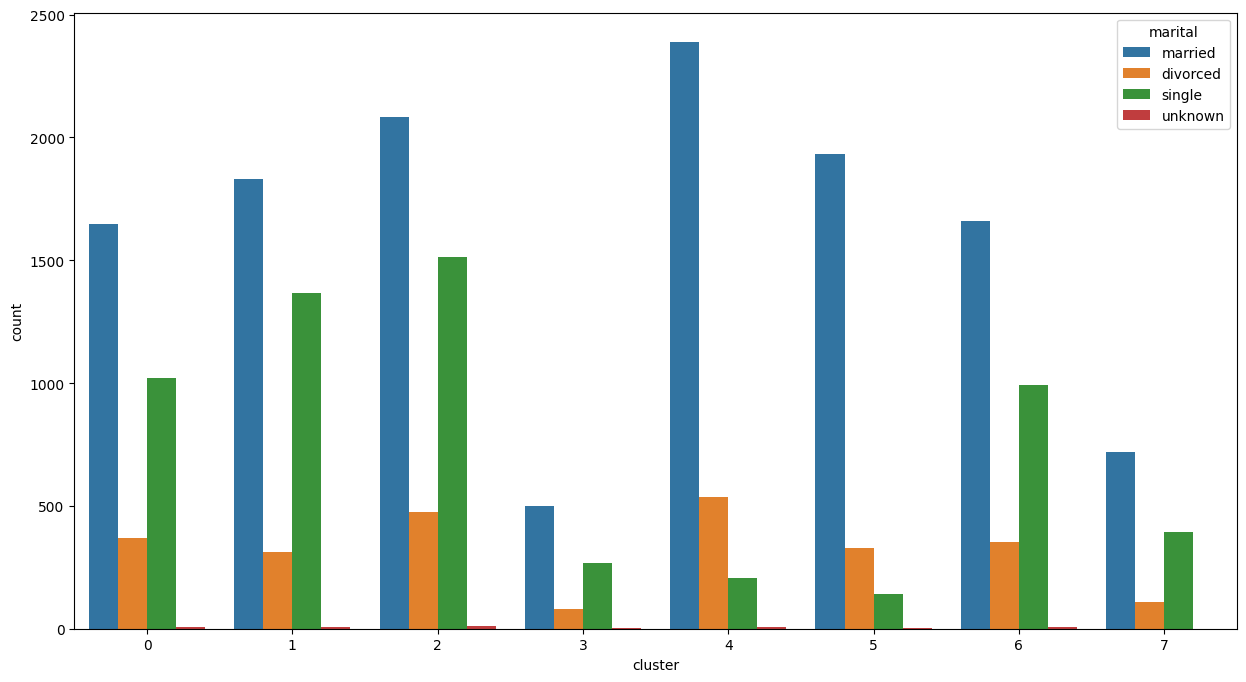

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x="cluster", hue="marital", data=cluster_data)

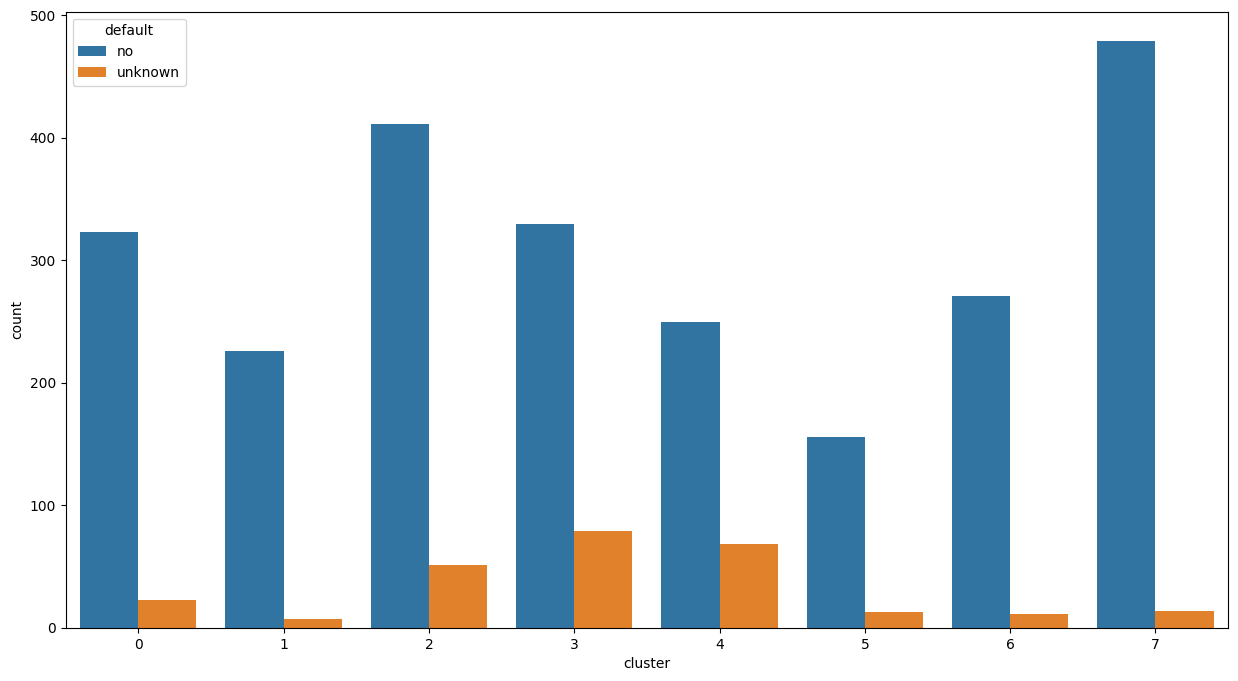

In [ ]:
plt.figure(figsize=(15,8))
# ax = sns.countplot(x="cluster", hue="housing", data=sample_customer)
ax = sns.countplot(x="cluster", hue="default", data=cluster_data.loc[(cluster_data['y']=='yes')])

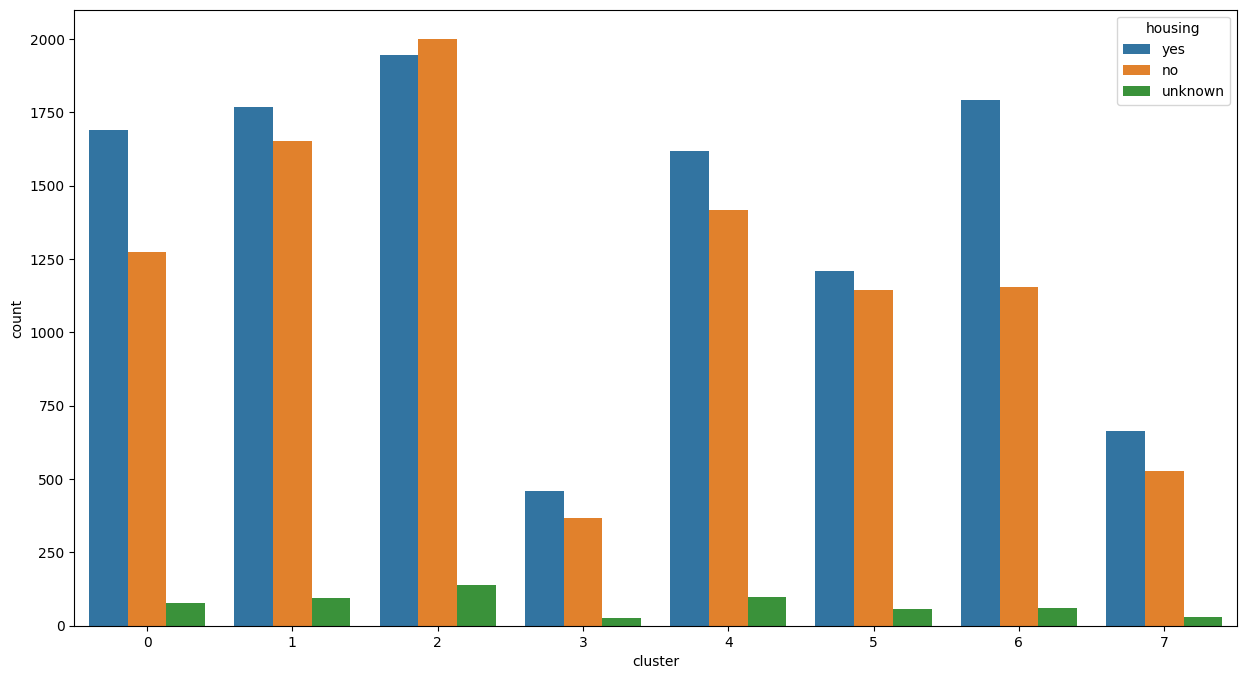

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x="cluster", hue="housing", data=cluster_data)

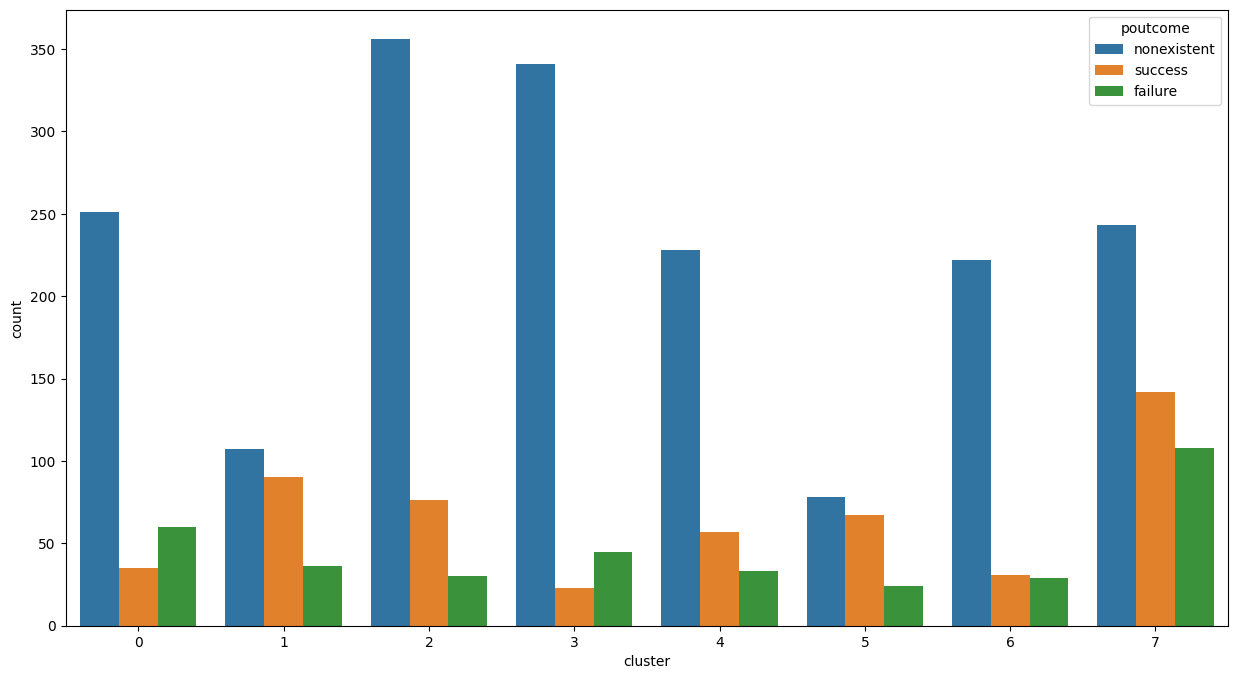

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x="cluster", hue="poutcome", data=cluster_data.loc[(cluster_data['y']=='yes')])